# Example of using the Borehole3D class

## Imports

In [1]:
from striplog import Component, Decor, Legend, Lexicon, Striplog
from core.omf import Borehole3D, striplog_legend_to_omf_legend 
from utils.lexicon.lexicon_memoris import lexicon_memoris, lithology_memoris
from utils.io import boreholes_from_files #, striplog_from_text, gdf_viewer, df_from_sources, striplog_from_df
from core.core import Project
from core.orm import BoreholeOrm, PositionOrm, Base 
import random
from os import remove
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from definitions import ROOT_DIR

/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/legend.py:687: UserWarning: This legend contains duplicate components.
  warnings.warn(w)
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/legend.py:687: UserWarning: This legend contains duplicate components.
  warnings.warn(w)


## Reading of CSV files in a dir

In [2]:
#df = pd.read_csv('test_data_boreholes.csv', sep=',') # use english lexicon
df = pd.read_csv('test_litho_fr.csv', sep=',') # use french lexicon

## Data Checking

In [5]:
df.head(5)

,ID,X,Y,Diameter,Length,Lithology,Colour,Thickness,Top_litho,Base_litho,Pollutant,Concentration,Unit
0,BH001,152600.0,121039.0,0.43,39,Sable,Jaune,4,0,4,Ni,35,mg/l
1,BH001,152600.0,121039.0,0.43,39,Argile,Vert,4,4,8,Ni,7,mg/l
2,BH001,152600.0,121039.0,0.43,39,Marne,Gris,12,8,20,As,69,mg/l
3,BH001,152600.0,121039.0,0.43,39,Charbon,Noir,8,20,28,As,73,mg/l
4,BH001,152600.0,121039.0,0.43,39,Calcaire,Bleu,11,28,39,As,12,mg/l


In [7]:
df.query('X==152013.0 and Y==121905.0')

,ID,X,Y,Z,Diameter,Length,Lithology,Colour,Thickness,Top_litho,Base_litho,Pollutant,Concentration,Unit
850,BH171,152013.0,121905.0,101.0,0.56,17,Sable,Jaune,2,0,2,Cl,75,mg/l
851,BH171,152013.0,121905.0,99.0,0.56,17,Argile,Vert,3,2,5,As,72,mg/l
852,BH171,152013.0,121905.0,96.0,0.56,17,Marne,Gris,6,5,11,Ni,69,mg/l
853,BH171,152013.0,121905.0,90.0,0.56,17,Charbon,Noir,3,11,14,Cl,63,mg/l
854,BH171,152013.0,121905.0,87.0,0.56,17,Calcaire,Bleu,3,14,17,As,81,mg/l


## Create Boreholes from dataframes or files

In [8]:
bhs_df=[df] # list of dataframes

In [9]:
boreholes, components, link_intv_comp = boreholes_from_files(bhs_df, verbose=False,
                                                litho_field='Lithology', color_field='Colour',
                                                lexicon=lexicon_memoris, diam_field='Diameter', 
                                                thick_field='Thickness')


Dataframe 0 processing...
|__ID:'BH001'
Summary : [Striplog(5 Intervals, start=0.0, stop=39.0)]
|__ID:'BH002'
Summary : [Striplog(5 Intervals, start=0.0, stop=37.0)]
|__ID:'BH003'
Summary : [Striplog(5 Intervals, start=0.0, stop=18.0)]
|__ID:'BH004'
Summary : [Striplog(5 Intervals, start=0.0, stop=26.0)]
|__ID:'BH005'
Summary : [Striplog(5 Intervals, start=0.0, stop=29.0)]
|__ID:'BH006'
Summary : [Striplog(5 Intervals, start=0.0, stop=26.0)]
|__ID:'BH007'
Summary : [Striplog(5 Intervals, start=0.0, stop=41.0)]
|__ID:'BH008'
Summary : [Striplog(5 Intervals, start=0.0, stop=35.0)]
|__ID:'BH009'
Summary : [Striplog(5 Intervals, start=0.0, stop=40.0)]
|__ID:'BH10'
Summary : [Striplog(5 Intervals, start=0.0, stop=31.0)]
|__ID:'BH011'
Summary : [Striplog(5 Intervals, start=0.0, stop=30.0)]
|__ID:'BH012'
Summary : [Striplog(5 Intervals, start=0.0, stop=41.0)]
|__ID:'BH013'
Summary : [Striplog(5 Intervals, start=0.0, stop=29.0)]
|__ID:'BH014'
Summary : [Striplog(5 Intervals, start=0.0, stop=2

/home/yanathan/Projects/GSDMA/utils/io.py:472: SAWarning: relationship 'ComponentOrm.intervals' will copy column Components.id to column Linkintervalcomponent.comp_id, which conflicts with relationship(s): 'IntervalOrm.components' (copies Components.id to Linkintervalcomponent.comp_id). If this is not the intention, consider if these relationships should be linked with back_populates, or if viewonly=True should be applied to one or more if they are read-only. For the less common case that foreign key constraints are partially overlapping, the orm.foreign() annotation can be used to isolate the columns that should be written towards.   The 'overlaps' parameter may be used to remove this warning.
  boreholes.append(BoreholeOrm(id=bh_name))
/home/yanathan/Projects/GSDMA/utils/io.py:472: SAWarning: relationship 'ComponentOrm.intervals' will copy column Intervals.id to column Linkintervalcomponent.int_id, which conflicts with relationship(s): 'IntervalOrm.components' (copies Intervals.id to

Summary : [Striplog(5 Intervals, start=0.0, stop=28.0)]
|__ID:'BH051'
Summary : [Striplog(5 Intervals, start=0.0, stop=22.0)]
|__ID:'BH052'
Summary : [Striplog(5 Intervals, start=0.0, stop=40.0)]
|__ID:'BH053'
Summary : [Striplog(5 Intervals, start=0.0, stop=12.0)]
|__ID:'BH054'
Summary : [Striplog(5 Intervals, start=0.0, stop=29.0)]
|__ID:'BH055'
Summary : [Striplog(5 Intervals, start=0.0, stop=25.0)]
|__ID:'BH056'
Summary : [Striplog(5 Intervals, start=0.0, stop=47.0)]
|__ID:'BH057'
Summary : [Striplog(5 Intervals, start=0.0, stop=45.0)]
|__ID:'BH058'
Summary : [Striplog(5 Intervals, start=0.0, stop=32.0)]
|__ID:'BH059'
Summary : [Striplog(5 Intervals, start=0.0, stop=43.0)]
|__ID:'BH060'
Summary : [Striplog(5 Intervals, start=0.0, stop=14.0)]
|__ID:'BH061'
Summary : [Striplog(5 Intervals, start=0.0, stop=26.0)]
|__ID:'BH062'
Summary : [Striplog(5 Intervals, start=0.0, stop=22.0)]
|__ID:'BH063'
Summary : [Striplog(5 Intervals, start=0.0, stop=35.0)]
|__ID:'BH064'
Summary : [Striplog(

|__ID:'BH177'
Summary : [Striplog(5 Intervals, start=0.0, stop=35.0)]
|__ID:'BH178'
Summary : [Striplog(5 Intervals, start=0.0, stop=30.0)]
|__ID:'BH179'
Summary : [Striplog(5 Intervals, start=0.0, stop=41.0)]
|__ID:'BH180'
Summary : [Striplog(5 Intervals, start=0.0, stop=34.0)]
|__ID:'BH181'
Summary : [Striplog(5 Intervals, start=0.0, stop=25.0)]
|__ID:'BH182'
Summary : [Striplog(5 Intervals, start=0.0, stop=39.0)]
|__ID:'BH183'
Summary : [Striplog(5 Intervals, start=0.0, stop=20.0)]
|__ID:'BH184'
Summary : [Striplog(5 Intervals, start=0.0, stop=35.0)]
|__ID:'BH185'
Summary : [Striplog(5 Intervals, start=0.0, stop=34.0)]
|__ID:'BH186'
Summary : [Striplog(5 Intervals, start=0.0, stop=18.0)]
|__ID:'BH187'
Summary : [Striplog(5 Intervals, start=0.0, stop=47.0)]
|__ID:'BH188'
Summary : [Striplog(5 Intervals, start=0.0, stop=34.0)]
|__ID:'BH189'
Summary : [Striplog(5 Intervals, start=0.0, stop=20.0)]
|__ID:'BH190'
Summary : [Striplog(5 Intervals, start=0.0, stop=33.0)]
|__ID:'BH191'
Summar

In [10]:
boreholes[170].intervals[850].top.x, boreholes[170].intervals[850].top.y

(152013.0, 121905.0)

In [11]:
boreholes

[<core.orm.BoreholeOrm>(Name=BH001, Length=39, Diameter=0.43, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH002, Length=37, Diameter=0.6, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH003, Length=18, Diameter=0.41, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH004, Length=26, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH005, Length=29, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH006, Length=26, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH007, Length=41, Diameter=0.57, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH008, Length=35, Diameter=0.39, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH009, Length=40, Diameter=0.5, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH10, Length=31, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH011, Length=30, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH012, Length=41, Diameter=0.54, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH013, Length=29, Diameter=0.36, Intervals=5),
 <core.orm.Bore

In [12]:
components

{0: Component({'lithology': 'marne'}),
 1: Component({'lithology': 'calcaire'}),
 2: Component({'lithology': 'charbon'}),
 3: Component({'lithology': 'sable'}),
 4: Component({'lithology': 'argile'})}

In [13]:
len(boreholes), len(components)

(199, 5)

## Create a project and save data in a database

In [14]:
remove('tmp_files/tfe_orm_db.db')

In [15]:
engine = create_engine('sqlite:///tmp_files/tfe_orm_db.db', echo=True)

In [16]:
Base.metadata.create_all(engine)

2021-06-25 17:15:32,883 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:32,884 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Boreholes")
2021-06-25 17:15:32,885 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-06-25 17:15:32,887 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Boreholes")
2021-06-25 17:15:32,888 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-06-25 17:15:32,888 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Positions")
2021-06-25 17:15:32,889 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-06-25 17:15:32,890 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Positions")
2021-06-25 17:15:32,891 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-06-25 17:15:32,891 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Intervals")
2021-06-25 17:15:32,892 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-06-25 17:15:32,893 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("Intervals")
2021-06-25 17:15:32,894 INFO sqlalchemy.engine.Engine 

In [17]:
Session = sessionmaker(bind=engine)
session = Session()

In [18]:
p = Project(session, legend_dict={'lithology':lithology_memoris}, lexicon=lexicon_memoris, 
            repr_attribute='lithology')
p.add_components(components)

2021-06-25 17:15:32,945 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:32,947 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:32,948 INFO sqlalchemy.engine.Engine [generated in 0.00096s] ()
2021-06-25 17:15:32,951 INFO sqlalchemy.engine.Engine INSERT INTO "Components" (id, description) VALUES (?, ?)
2021-06-25 17:15:32,952 INFO sqlalchemy.engine.Engine [generated in 0.00056s] ((0, 'Marne'), (1, 'Calcaire'), (2, 'Charbon'), (3, 'Sable'), (4, 'Argile'))
2021-06-25 17:15:32,953 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:32,957 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:32,958 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:32,958 INFO sqlalchemy.engine.Eng

Add boreholes into the project

In [19]:
for bh in boreholes:
    p.add_borehole(bh)

2021-06-25 17:15:32,966 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-25 17:15:32,967 INFO sqlalchemy.engine.Engine [generated in 0.00115s] ('BH001', 39.0, 0.43)
2021-06-25 17:15:32,971 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:32,972 INFO sqlalchemy.engine.Engine [generated in 0.00080s] ((0, 0.0, 0.0, 0.0, 152600.0, 121039.0), (1, 4.0, 4.0, 4.0, 152600.0, 121039.0), (2, 4.0, 4.0, 4.0, 152600.0, 121039.0), (3, 8.0, 8.0, 8.0, 152600.0, 121039.0), (4, 8.0, 8.0, 8.0, 152600.0, 121039.0), (5, 20.0, 20.0, 20.0, 152600.0, 121039.0), (6, 20.0, 20.0, 20.0, 152600.0, 121039.0), (7, 28.0, 28.0, 28.0, 152600.0, 121039.0), (8, 28.0, 28.0, 28.0, 152600.0, 121039.0), (9, 39.0, 39.0, 39.0, 152600.0, 121039.0))
2021-06-25 17:15:32,974 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, 

2021-06-25 17:15:33,035 INFO sqlalchemy.engine.Engine [cached since 0.04852s ago] ('BH002',)
2021-06-25 17:15:33,037 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,038 INFO sqlalchemy.engine.Engine [cached since 0.04707s ago] (10,)
2021-06-25 17:15:33,039 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,040 INFO sqlalchemy.engine.Engine [cached since 0.04594s ago] (11,)
2021-06-25 17:15:33,041 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Pos

2021-06-25 17:15:33,097 INFO sqlalchemy.engine.Engine [cached since 0.1065s ago] (24,)
2021-06-25 17:15:33,099 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,100 INFO sqlalchemy.engine.Engine [cached since 0.106s ago] (25,)
2021-06-25 17:15:33,102 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,103 INFO sqlalchemy.engine.Engine [cached since 0.1122s ago] (26,)
2021-06-25 17:15:33,105 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-06-25 17:15:33,160 INFO sqlalchemy.engine.Engine [cached since 0.166s ago] (39,)
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-25 17:15:33,169 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-25 17:15:33,170 INFO sqlalchemy.engine.Engine [cached since 0.2041s ago] ('BH005', 29.0, 0.61)
2021-06-25 17:15:33,171 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:33,171 INFO sqlalchemy.engine.Engine [cached since 0.1999s ago] ((40, 0.0, 0.0, 0.0, 152473.0, 121460.0), (41, 4.0, 4.0, 4.0, 152473.0, 121460.0), (42, 4.0, 4.0, 4.0, 152473.0, 121460.0), (43, 8.0, 8.0, 8.0, 152473.0, 121460.0), (44, 8.0, 8.0, 8.0, 152473.0, 121460.0), (45, 19.0, 19.0, 19.0, 152473.0, 121460.0), (46, 19.0, 19.0, 19.0, 152473.0, 121460.0), (47, 27.0, 27.0, 27.0, 152473.0, 121460.0), (48, 27.0, 27.0, 27.0, 152473.0, 121460.0), (49, 29.0, 

2021-06-25 17:15:33,231 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:33,232 INFO sqlalchemy.engine.Engine [cached since 0.2456s ago] ('BH006',)
2021-06-25 17:15:33,234 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,235 INFO sqlalchemy.engine.Engine [cached since 0.2442s ago] (50,)
2021-06-25 17:15:33,237 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".up

2021-06-25 17:15:33,290 INFO sqlalchemy.engine.Engine [cached since 0.2962s ago] (63,)
2021-06-25 17:15:33,292 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,292 INFO sqlalchemy.engine.Engine [cached since 0.3016s ago] (64,)
2021-06-25 17:15:33,294 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,295 INFO sqlalchemy.engine.Engine [cached since 0.3008s ago] (65,)
2021-06-25 17:15:33,297 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:33,353 INFO sqlalchemy.engine.Engine [cached since 0.3624s ago] (78,)
2021-06-25 17:15:33,354 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,355 INFO sqlalchemy.engine.Engine [cached since 0.3612s ago] (79,)
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-25 17:15:33,367 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-25 17:15:33,368 INFO sqlalchemy.engine.Engine [cached since 0.4023s ago] ('BH009', 40.0, 0.5)
2021-06-25 17:15:33,370 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:33,370 INFO sqlalchemy.engine.Engine [cached s

2021-06-25 17:15:33,428 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:33,432 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:33,434 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:33,435 INFO sqlalchemy.engine.Engine [cached since 0.4875s ago] ()
2021-06-25 17:15:33,437 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:33,438 INFO sqlalchemy.engine.Engine [cached since 0.4511s ago] ('BH10',)
2021-06-25 17:15:33,439 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions

2021-06-25 17:15:33,499 INFO sqlalchemy.engine.Engine [cached since 0.5087s ago] (102,)
2021-06-25 17:15:33,501 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,502 INFO sqlalchemy.engine.Engine [cached since 0.5081s ago] (103,)
2021-06-25 17:15:33,504 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,504 INFO sqlalchemy.engine.Engine [cached since 0.5136s ago] (104,)
2021-06-25 17:15:33,506 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:33,563 INFO sqlalchemy.engine.Engine [cached since 0.5691s ago] (117,)
2021-06-25 17:15:33,565 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,566 INFO sqlalchemy.engine.Engine [cached since 0.5753s ago] (118,)
2021-06-25 17:15:33,568 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,569 INFO sqlalchemy.engine.Engine [cached since 0.575s ago] (119,)
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06

2021-06-25 17:15:33,634 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:33,635 INFO sqlalchemy.engine.Engine [cached since 0.661s ago] ((65, 'BH014', 0, 'Sable', 130, 131), (66, 'BH014', 1, 'Argile', 132, 133), (67, 'BH014', 2, 'Marne', 134, 135), (68, 'BH014', 3, 'Charbon', 136, 137), (69, 'BH014', 4, 'Calcaire', 138, 139))
2021-06-25 17:15:33,636 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:33,639 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:33,640 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:33,640 INFO sqlalchemy.engine.Engine [cached since 0.6933s ago] ()
2021-06-25 17:15:33,642 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Inte

2021-06-25 17:15:33,703 INFO sqlalchemy.engine.Engine [cached since 0.7091s ago] (141,)
2021-06-25 17:15:33,705 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,706 INFO sqlalchemy.engine.Engine [cached since 0.7149s ago] (142,)
2021-06-25 17:15:33,707 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,708 INFO sqlalchemy.engine.Engine [cached since 0.7139s ago] (143,)
2021-06-25 17:15:33,710 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:33,762 INFO sqlalchemy.engine.Engine [cached since 0.7711s ago] (156,)
2021-06-25 17:15:33,764 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,765 INFO sqlalchemy.engine.Engine [cached since 0.771s ago] (157,)
2021-06-25 17:15:33,767 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,768 INFO sqlalchemy.engine.Engine [cached since 0.7772s ago] (158,)
2021-06-25 17:15:33,770 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions

2021-06-25 17:15:33,829 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:33,830 INFO sqlalchemy.engine.Engine [cached since 0.8568s ago] ((85, 'BH018', 0, 'Sable', 170, 171), (86, 'BH018', 1, 'Argile', 172, 173), (87, 'BH018', 2, 'Marne', 174, 175), (88, 'BH018', 3, 'Charbon', 176, 177), (89, 'BH018', 4, 'Calcaire', 178, 179))
2021-06-25 17:15:33,832 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:33,834 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:33,835 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:33,835 INFO sqlalchemy.engine.Engine [cached since 0.888s ago] ()
2021-06-25 17:15:33,837 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Inte

2021-06-25 17:15:33,891 INFO sqlalchemy.engine.Engine [cached since 0.8976s ago] (181,)
2021-06-25 17:15:33,893 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,893 INFO sqlalchemy.engine.Engine [cached since 0.9028s ago] (182,)
2021-06-25 17:15:33,895 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,896 INFO sqlalchemy.engine.Engine [cached since 0.9021s ago] (183,)
2021-06-25 17:15:33,898 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:33,954 INFO sqlalchemy.engine.Engine [cached since 0.9637s ago] (196,)
2021-06-25 17:15:33,956 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,957 INFO sqlalchemy.engine.Engine [cached since 0.9633s ago] (197,)
2021-06-25 17:15:33,959 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:33,960 INFO sqlalchemy.engine.Engine [cached since 0.9691s ago] (198,)
2021-06-25 17:15:33,962 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:34,036 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:34,036 INFO sqlalchemy.engine.Engine [cached since 1.063s ago] ((105, 'BH022', 0, 'Sable', 210, 211), (106, 'BH022', 1, 'Argile', 212, 213), (107, 'BH022', 2, 'Marne', 214, 215), (108, 'BH022', 3, 'Charbon', 216, 217), (109, 'BH022', 4, 'Calcaire', 218, 219))
2021-06-25 17:15:34,037 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:34,040 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:34,041 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:34,041 INFO sqlalchemy.engine.Engine [cached since 1.094s ago] ()
2021-06-25 17:15:34,043 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "

2021-06-25 17:15:34,095 INFO sqlalchemy.engine.Engine [cached since 1.101s ago] (221,)
2021-06-25 17:15:34,098 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:34,099 INFO sqlalchemy.engine.Engine [cached since 1.108s ago] (222,)
2021-06-25 17:15:34,101 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:34,102 INFO sqlalchemy.engine.Engine [cached since 1.108s ago] (223,)
2021-06-25 17:15:34,104 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:34,158 INFO sqlalchemy.engine.Engine [cached since 1.167s ago] (236,)
2021-06-25 17:15:34,159 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:34,159 INFO sqlalchemy.engine.Engine [cached since 1.166s ago] (237,)
2021-06-25 17:15:34,161 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:34,161 INFO sqlalchemy.engine.Engine [cached since 1.171s ago] (238,)
2021-06-25 17:15:34,163 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:34,235 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:34,236 INFO sqlalchemy.engine.Engine [cached since 1.262s ago] ((125, 'BH026', 0, 'Sable', 250, 251), (126, 'BH026', 1, 'Argile', 252, 253), (127, 'BH026', 2, 'Marne', 254, 255), (128, 'BH026', 3, 'Charbon', 256, 257), (129, 'BH026', 4, 'Calcaire', 258, 259))
2021-06-25 17:15:34,238 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:34,242 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:34,242 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:34,243 INFO sqlalchemy.engine.Engine [cached since 1.296s ago] ()
2021-06-25 17:15:34,245 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "

2021-06-25 17:15:34,309 INFO sqlalchemy.engine.Engine [cached since 1.315s ago] (261,)
2021-06-25 17:15:34,311 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:34,312 INFO sqlalchemy.engine.Engine [cached since 1.322s ago] (262,)
2021-06-25 17:15:34,314 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:34,315 INFO sqlalchemy.engine.Engine [cached since 1.321s ago] (263,)
2021-06-25 17:15:34,317 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:34,375 INFO sqlalchemy.engine.Engine [cached since 1.384s ago] (276,)
2021-06-25 17:15:34,376 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:34,377 INFO sqlalchemy.engine.Engine [cached since 1.384s ago] (277,)
2021-06-25 17:15:34,379 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:34,381 INFO sqlalchemy.engine.Engine [cached since 1.39s ago] (278,)
2021-06-25 17:15:34,382 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-06-25 17:15:34,448 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:34,448 INFO sqlalchemy.engine.Engine [cached since 1.475s ago] ((145, 'BH030', 0, 'Sable', 290, 291), (146, 'BH030', 1, 'Argile', 292, 293), (147, 'BH030', 2, 'Marne', 294, 295), (148, 'BH030', 3, 'Charbon', 296, 297), (149, 'BH030', 4, 'Calcaire', 298, 299))
2021-06-25 17:15:34,450 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:34,454 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:34,454 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:34,455 INFO sqlalchemy.engine.Engine [cached since 1.508s ago] ()
2021-06-25 17:15:34,456 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "

2021-06-25 17:15:34,513 INFO sqlalchemy.engine.Engine [cached since 1.519s ago] (301,)
2021-06-25 17:15:34,515 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:34,516 INFO sqlalchemy.engine.Engine [cached since 1.525s ago] (302,)
2021-06-25 17:15:34,518 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:34,519 INFO sqlalchemy.engine.Engine [cached since 1.526s ago] (303,)
2021-06-25 17:15:34,522 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:34,575 INFO sqlalchemy.engine.Engine [cached since 1.584s ago] (316,)
2021-06-25 17:15:34,577 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:34,578 INFO sqlalchemy.engine.Engine [cached since 1.584s ago] (317,)
2021-06-25 17:15:34,580 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:34,581 INFO sqlalchemy.engine.Engine [cached since 1.59s ago] (318,)
2021-06-25 17:15:34,583 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-06-25 17:15:34,663 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:34,663 INFO sqlalchemy.engine.Engine [cached since 1.69s ago] ((165, 'BH034', 0, 'Sable', 330, 331), (166, 'BH034', 1, 'Argile', 332, 333), (167, 'BH034', 2, 'Marne', 334, 335), (168, 'BH034', 3, 'Charbon', 336, 337), (169, 'BH034', 4, 'Calcaire', 338, 339))
2021-06-25 17:15:34,665 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:34,669 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:34,670 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:34,671 INFO sqlalchemy.engine.Engine [cached since 1.723s ago] ()
2021-06-25 17:15:34,673 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "I

2021-06-25 17:15:34,728 INFO sqlalchemy.engine.Engine [cached since 1.734s ago] (341,)
2021-06-25 17:15:34,730 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:34,730 INFO sqlalchemy.engine.Engine [cached since 1.74s ago] (342,)
2021-06-25 17:15:34,732 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:34,732 INFO sqlalchemy.engine.Engine [cached since 1.738s ago] (343,)
2021-06-25 17:15:34,733 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-06-25 17:15:34,794 INFO sqlalchemy.engine.Engine [cached since 1.804s ago] (356,)
2021-06-25 17:15:34,796 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:34,797 INFO sqlalchemy.engine.Engine [cached since 1.803s ago] (357,)
2021-06-25 17:15:34,799 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:34,800 INFO sqlalchemy.engine.Engine [cached since 1.81s ago] (358,)
2021-06-25 17:15:34,802 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-06-25 17:15:34,873 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:34,874 INFO sqlalchemy.engine.Engine [cached since 1.9s ago] ((185, 'BH038', 0, 'Sable', 370, 371), (186, 'BH038', 1, 'Argile', 372, 373), (187, 'BH038', 2, 'Marne', 374, 375), (188, 'BH038', 3, 'Charbon', 376, 377), (189, 'BH038', 4, 'Calcaire', 378, 379))
2021-06-25 17:15:34,875 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:34,879 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:34,880 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:34,881 INFO sqlalchemy.engine.Engine [cached since 1.934s ago] ()
2021-06-25 17:15:34,884 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "In

2021-06-25 17:15:34,936 INFO sqlalchemy.engine.Engine [cached since 1.942s ago] (381,)
2021-06-25 17:15:34,938 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:34,939 INFO sqlalchemy.engine.Engine [cached since 1.948s ago] (382,)
2021-06-25 17:15:34,940 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:34,941 INFO sqlalchemy.engine.Engine [cached since 1.948s ago] (383,)
2021-06-25 17:15:34,943 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:35,007 INFO sqlalchemy.engine.Engine [cached since 2.016s ago] (396,)
2021-06-25 17:15:35,008 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:35,009 INFO sqlalchemy.engine.Engine [cached since 2.015s ago] (397,)
2021-06-25 17:15:35,011 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:35,013 INFO sqlalchemy.engine.Engine [cached since 2.022s ago] (398,)
2021-06-25 17:15:35,015 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:35,078 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:35,079 INFO sqlalchemy.engine.Engine [cached since 2.105s ago] ((205, 'BH042', 0, 'Sable', 410, 411), (206, 'BH042', 1, 'Argile', 412, 413), (207, 'BH042', 2, 'Marne', 414, 415), (208, 'BH042', 3, 'Charbon', 416, 417), (209, 'BH042', 4, 'Calcaire', 418, 419))
2021-06-25 17:15:35,081 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:35,084 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:35,085 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:35,086 INFO sqlalchemy.engine.Engine [cached since 2.139s ago] ()
2021-06-25 17:15:35,089 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "

2021-06-25 17:15:35,148 INFO sqlalchemy.engine.Engine [cached since 2.154s ago] (421,)
2021-06-25 17:15:35,151 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:35,151 INFO sqlalchemy.engine.Engine [cached since 2.161s ago] (422,)
2021-06-25 17:15:35,154 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:35,155 INFO sqlalchemy.engine.Engine [cached since 2.161s ago] (423,)
2021-06-25 17:15:35,157 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:35,221 INFO sqlalchemy.engine.Engine [cached since 2.23s ago] (436,)
2021-06-25 17:15:35,223 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:35,224 INFO sqlalchemy.engine.Engine [cached since 2.23s ago] (437,)
2021-06-25 17:15:35,225 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:35,226 INFO sqlalchemy.engine.Engine [cached since 2.235s ago] (438,)
2021-06-25 17:15:35,228 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id"

2021-06-25 17:15:35,300 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:35,301 INFO sqlalchemy.engine.Engine [cached since 2.327s ago] ((225, 'BH046', 0, 'Sable', 450, 451), (226, 'BH046', 1, 'Argile', 452, 453), (227, 'BH046', 2, 'Marne', 454, 455), (228, 'BH046', 3, 'Charbon', 456, 457), (229, 'BH046', 4, 'Calcaire', 458, 459))
2021-06-25 17:15:35,303 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:35,308 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:35,309 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:35,310 INFO sqlalchemy.engine.Engine [cached since 2.363s ago] ()
2021-06-25 17:15:35,313 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "

2021-06-25 17:15:35,365 INFO sqlalchemy.engine.Engine [cached since 2.372s ago] (461,)
2021-06-25 17:15:35,367 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:35,368 INFO sqlalchemy.engine.Engine [cached since 2.377s ago] (462,)
2021-06-25 17:15:35,370 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:35,371 INFO sqlalchemy.engine.Engine [cached since 2.377s ago] (463,)
2021-06-25 17:15:35,373 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:35,433 INFO sqlalchemy.engine.Engine [cached since 2.442s ago] (476,)
2021-06-25 17:15:35,434 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:35,435 INFO sqlalchemy.engine.Engine [cached since 2.441s ago] (477,)
2021-06-25 17:15:35,436 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:35,437 INFO sqlalchemy.engine.Engine [cached since 2.446s ago] (478,)
2021-06-25 17:15:35,438 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:35,503 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:35,504 INFO sqlalchemy.engine.Engine [cached since 2.53s ago] ((245, 'BH050', 0, 'Sable', 490, 491), (246, 'BH050', 1, 'Argile', 492, 493), (247, 'BH050', 2, 'Marne', 494, 495), (248, 'BH050', 3, 'Charbon', 496, 497), (249, 'BH050', 4, 'Calcaire', 498, 499))
2021-06-25 17:15:35,505 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:35,509 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:35,510 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:35,511 INFO sqlalchemy.engine.Engine [cached since 2.564s ago] ()
2021-06-25 17:15:35,514 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "I

2021-06-25 17:15:35,574 INFO sqlalchemy.engine.Engine [cached since 2.58s ago] (501,)
2021-06-25 17:15:35,576 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:35,577 INFO sqlalchemy.engine.Engine [cached since 2.586s ago] (502,)
2021-06-25 17:15:35,578 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:35,579 INFO sqlalchemy.engine.Engine [cached since 2.585s ago] (503,)
2021-06-25 17:15:35,581 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-06-25 17:15:35,642 INFO sqlalchemy.engine.Engine [cached since 2.651s ago] (516,)
2021-06-25 17:15:35,644 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:35,645 INFO sqlalchemy.engine.Engine [cached since 2.652s ago] (517,)
2021-06-25 17:15:35,648 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:35,649 INFO sqlalchemy.engine.Engine [cached since 2.659s ago] (518,)
2021-06-25 17:15:35,651 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:35,722 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:35,723 INFO sqlalchemy.engine.Engine [cached since 2.749s ago] ((265, 'BH054', 0, 'Sable', 530, 531), (266, 'BH054', 1, 'Argile', 532, 533), (267, 'BH054', 2, 'Marne', 534, 535), (268, 'BH054', 3, 'Charbon', 536, 537), (269, 'BH054', 4, 'Calcaire', 538, 539))
2021-06-25 17:15:35,724 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:35,729 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:35,729 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:35,730 INFO sqlalchemy.engine.Engine [cached since 2.783s ago] ()
2021-06-25 17:15:35,732 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "

2021-06-25 17:15:35,788 INFO sqlalchemy.engine.Engine [cached since 2.794s ago] (541,)
2021-06-25 17:15:35,790 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:35,791 INFO sqlalchemy.engine.Engine [cached since 2.8s ago] (542,)
2021-06-25 17:15:35,792 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:35,793 INFO sqlalchemy.engine.Engine [cached since 2.799s ago] (543,)
2021-06-25 17:15:35,795 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id"

2021-06-25 17:15:35,859 INFO sqlalchemy.engine.Engine [cached since 2.868s ago] (556,)
2021-06-25 17:15:35,860 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:35,861 INFO sqlalchemy.engine.Engine [cached since 2.867s ago] (557,)
2021-06-25 17:15:35,862 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:35,863 INFO sqlalchemy.engine.Engine [cached since 2.872s ago] (558,)
2021-06-25 17:15:35,864 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:35,939 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:35,940 INFO sqlalchemy.engine.Engine [cached since 2.966s ago] ((285, 'BH058', 0, 'Sable', 570, 571), (286, 'BH058', 1, 'Argile', 572, 573), (287, 'BH058', 2, 'Marne', 574, 575), (288, 'BH058', 3, 'Charbon', 576, 577), (289, 'BH058', 4, 'Calcaire', 578, 579))
2021-06-25 17:15:35,941 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:35,945 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:35,946 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:35,947 INFO sqlalchemy.engine.Engine [cached since 3s ago] ()
2021-06-25 17:15:35,949 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Inte

2021-06-25 17:15:36,008 INFO sqlalchemy.engine.Engine [cached since 3.014s ago] (581,)
2021-06-25 17:15:36,009 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,010 INFO sqlalchemy.engine.Engine [cached since 3.02s ago] (582,)
2021-06-25 17:15:36,012 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,013 INFO sqlalchemy.engine.Engine [cached since 3.019s ago] (583,)
2021-06-25 17:15:36,014 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-06-25 17:15:36,068 INFO sqlalchemy.engine.Engine [cached since 3.077s ago] (596,)
2021-06-25 17:15:36,069 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,070 INFO sqlalchemy.engine.Engine [cached since 3.076s ago] (597,)
2021-06-25 17:15:36,072 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,073 INFO sqlalchemy.engine.Engine [cached since 3.082s ago] (598,)
2021-06-25 17:15:36,075 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:36,144 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:36,145 INFO sqlalchemy.engine.Engine [cached since 3.172s ago] ((305, 'BH062', 0, 'Sable', 610, 611), (306, 'BH062', 1, 'Argile', 612, 613), (307, 'BH062', 2, 'Marne', 614, 615), (308, 'BH062', 3, 'Charbon', 616, 617), (309, 'BH062', 4, 'Calcaire', 618, 619))
2021-06-25 17:15:36,147 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:36,151 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:36,152 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:36,153 INFO sqlalchemy.engine.Engine [cached since 3.206s ago] ()
2021-06-25 17:15:36,157 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "

2021-06-25 17:15:36,215 INFO sqlalchemy.engine.Engine [cached since 3.222s ago] (621,)
2021-06-25 17:15:36,217 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,218 INFO sqlalchemy.engine.Engine [cached since 3.227s ago] (622,)
2021-06-25 17:15:36,220 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,220 INFO sqlalchemy.engine.Engine [cached since 3.226s ago] (623,)
2021-06-25 17:15:36,222 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:36,276 INFO sqlalchemy.engine.Engine [cached since 3.286s ago] (636,)
2021-06-25 17:15:36,277 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,278 INFO sqlalchemy.engine.Engine [cached since 3.284s ago] (637,)
2021-06-25 17:15:36,280 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,281 INFO sqlalchemy.engine.Engine [cached since 3.29s ago] (638,)
2021-06-25 17:15:36,283 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-06-25 17:15:36,363 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:36,365 INFO sqlalchemy.engine.Engine [cached since 3.391s ago] ((325, 'BH066', 0, 'Sable', 650, 651), (326, 'BH066', 1, 'Argile', 652, 653), (327, 'BH066', 2, 'Marne', 654, 655), (328, 'BH066', 3, 'Charbon', 656, 657), (329, 'BH066', 4, 'Calcaire', 658, 659))
2021-06-25 17:15:36,367 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:36,371 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:36,372 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:36,373 INFO sqlalchemy.engine.Engine [cached since 3.426s ago] ()
2021-06-25 17:15:36,375 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "

2021-06-25 17:15:36,442 INFO sqlalchemy.engine.Engine [cached since 3.448s ago] (661,)
2021-06-25 17:15:36,444 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,445 INFO sqlalchemy.engine.Engine [cached since 3.454s ago] (662,)
2021-06-25 17:15:36,447 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,448 INFO sqlalchemy.engine.Engine [cached since 3.454s ago] (663,)
2021-06-25 17:15:36,450 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:36,520 INFO sqlalchemy.engine.Engine [cached since 3.53s ago] (676,)
2021-06-25 17:15:36,522 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,522 INFO sqlalchemy.engine.Engine [cached since 3.529s ago] (677,)
2021-06-25 17:15:36,525 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,525 INFO sqlalchemy.engine.Engine [cached since 3.535s ago] (678,)
2021-06-25 17:15:36,527 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-06-25 17:15:36,600 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:36,601 INFO sqlalchemy.engine.Engine [cached since 3.627s ago] ((345, 'BH070', 0, 'Sable', 690, 691), (346, 'BH070', 1, 'Argile', 692, 693), (347, 'BH070', 2, 'Marne', 694, 695), (348, 'BH070', 3, 'Charbon', 696, 697), (349, 'BH070', 4, 'Calcaire', 698, 699))
2021-06-25 17:15:36,602 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:36,607 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:36,608 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:36,608 INFO sqlalchemy.engine.Engine [cached since 3.661s ago] ()
2021-06-25 17:15:36,611 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "

2021-06-25 17:15:36,666 INFO sqlalchemy.engine.Engine [cached since 3.673s ago] (701,)
2021-06-25 17:15:36,668 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,669 INFO sqlalchemy.engine.Engine [cached since 3.678s ago] (702,)
2021-06-25 17:15:36,670 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,671 INFO sqlalchemy.engine.Engine [cached since 3.677s ago] (703,)
2021-06-25 17:15:36,672 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:36,741 INFO sqlalchemy.engine.Engine [cached since 3.75s ago] (716,)
2021-06-25 17:15:36,742 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,742 INFO sqlalchemy.engine.Engine [cached since 3.749s ago] (717,)
2021-06-25 17:15:36,744 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,744 INFO sqlalchemy.engine.Engine [cached since 3.753s ago] (718,)
2021-06-25 17:15:36,745 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-06-25 17:15:36,825 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:36,826 INFO sqlalchemy.engine.Engine [cached since 3.852s ago] ((365, 'BH074', 0, 'Sable', 730, 731), (366, 'BH074', 1, 'Argile', 732, 733), (367, 'BH074', 2, 'Marne', 734, 735), (368, 'BH074', 3, 'Charbon', 736, 737), (369, 'BH074', 4, 'Calcaire', 738, 739))
2021-06-25 17:15:36,827 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:36,832 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:36,832 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:36,833 INFO sqlalchemy.engine.Engine [cached since 3.886s ago] ()
2021-06-25 17:15:36,836 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "

2021-06-25 17:15:36,893 INFO sqlalchemy.engine.Engine [cached since 3.9s ago] (741,)
2021-06-25 17:15:36,896 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,897 INFO sqlalchemy.engine.Engine [cached since 3.907s ago] (742,)
2021-06-25 17:15:36,899 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,900 INFO sqlalchemy.engine.Engine [cached since 3.906s ago] (743,)
2021-06-25 17:15:36,901 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id"

2021-06-25 17:15:36,963 INFO sqlalchemy.engine.Engine [cached since 3.973s ago] (756,)
2021-06-25 17:15:36,965 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,966 INFO sqlalchemy.engine.Engine [cached since 3.972s ago] (757,)
2021-06-25 17:15:36,968 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:36,970 INFO sqlalchemy.engine.Engine [cached since 3.979s ago] (758,)
2021-06-25 17:15:36,972 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:37,051 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:37,051 INFO sqlalchemy.engine.Engine [cached since 4.078s ago] ((385, 'BH078', 0, 'Sable', 770, 771), (386, 'BH078', 1, 'Argile', 772, 773), (387, 'BH078', 2, 'Marne', 774, 775), (388, 'BH078', 3, 'Charbon', 776, 777), (389, 'BH078', 4, 'Calcaire', 778, 779))
2021-06-25 17:15:37,054 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:37,058 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:37,060 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:37,061 INFO sqlalchemy.engine.Engine [cached since 4.114s ago] ()
2021-06-25 17:15:37,064 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "

2021-06-25 17:15:37,132 INFO sqlalchemy.engine.Engine [cached since 4.138s ago] (781,)
2021-06-25 17:15:37,133 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:37,134 INFO sqlalchemy.engine.Engine [cached since 4.143s ago] (782,)
2021-06-25 17:15:37,134 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:37,135 INFO sqlalchemy.engine.Engine [cached since 4.141s ago] (783,)
2021-06-25 17:15:37,137 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:37,196 INFO sqlalchemy.engine.Engine [cached since 4.205s ago] (796,)
2021-06-25 17:15:37,198 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:37,199 INFO sqlalchemy.engine.Engine [cached since 4.205s ago] (797,)
2021-06-25 17:15:37,200 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:37,201 INFO sqlalchemy.engine.Engine [cached since 4.211s ago] (798,)
2021-06-25 17:15:37,203 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:37,275 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:37,276 INFO sqlalchemy.engine.Engine [cached since 4.302s ago] ((405, 'BH082', 0, 'Sable', 810, 811), (406, 'BH082', 1, 'Argile', 812, 813), (407, 'BH082', 2, 'Marne', 814, 815), (408, 'BH082', 3, 'Charbon', 816, 817), (409, 'BH082', 4, 'Calcaire', 818, 819))
2021-06-25 17:15:37,277 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:37,281 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:37,282 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:37,283 INFO sqlalchemy.engine.Engine [cached since 4.335s ago] ()
2021-06-25 17:15:37,285 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "

2021-06-25 17:15:37,343 INFO sqlalchemy.engine.Engine [cached since 4.35s ago] (821,)
2021-06-25 17:15:37,345 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:37,345 INFO sqlalchemy.engine.Engine [cached since 4.355s ago] (822,)
2021-06-25 17:15:37,347 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:37,348 INFO sqlalchemy.engine.Engine [cached since 4.354s ago] (823,)
2021-06-25 17:15:37,350 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-06-25 17:15:37,406 INFO sqlalchemy.engine.Engine [cached since 4.415s ago] (836,)
2021-06-25 17:15:37,407 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:37,408 INFO sqlalchemy.engine.Engine [cached since 4.414s ago] (837,)
2021-06-25 17:15:37,409 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:37,410 INFO sqlalchemy.engine.Engine [cached since 4.42s ago] (838,)
2021-06-25 17:15:37,412 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-06-25 17:15:37,486 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:37,487 INFO sqlalchemy.engine.Engine [cached since 4.513s ago] ((425, 'BH086', 0, 'Sable', 850, 851), (426, 'BH086', 1, 'Argile', 852, 853), (427, 'BH086', 2, 'Marne', 854, 855), (428, 'BH086', 3, 'Charbon', 856, 857), (429, 'BH086', 4, 'Calcaire', 858, 859))
2021-06-25 17:15:37,489 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:37,494 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:37,494 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:37,495 INFO sqlalchemy.engine.Engine [cached since 4.548s ago] ()
2021-06-25 17:15:37,498 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "

2021-06-25 17:15:37,564 INFO sqlalchemy.engine.Engine [cached since 4.57s ago] (861,)
2021-06-25 17:15:37,566 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:37,567 INFO sqlalchemy.engine.Engine [cached since 4.576s ago] (862,)
2021-06-25 17:15:37,568 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:37,569 INFO sqlalchemy.engine.Engine [cached since 4.575s ago] (863,)
2021-06-25 17:15:37,571 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id

2021-06-25 17:15:37,623 INFO sqlalchemy.engine.Engine [cached since 4.633s ago] (876,)
2021-06-25 17:15:37,625 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:37,625 INFO sqlalchemy.engine.Engine [cached since 4.631s ago] (877,)
2021-06-25 17:15:37,627 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:37,628 INFO sqlalchemy.engine.Engine [cached since 4.637s ago] (878,)
2021-06-25 17:15:37,629 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:37,691 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:37,692 INFO sqlalchemy.engine.Engine [cached since 4.718s ago] ((445, 'BH090', 0, 'Sable', 890, 891), (446, 'BH090', 1, 'Argile', 892, 893), (447, 'BH090', 2, 'Marne', 894, 895), (448, 'BH090', 3, 'Charbon', 896, 897), (449, 'BH090', 4, 'Calcaire', 898, 899))
2021-06-25 17:15:37,694 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:37,699 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:37,699 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:37,700 INFO sqlalchemy.engine.Engine [cached since 4.753s ago] ()
2021-06-25 17:15:37,703 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "

2021-06-25 17:15:37,757 INFO sqlalchemy.engine.Engine [cached since 4.763s ago] (901,)
2021-06-25 17:15:37,758 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:37,760 INFO sqlalchemy.engine.Engine [cached since 4.769s ago] (902,)
2021-06-25 17:15:37,761 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:37,762 INFO sqlalchemy.engine.Engine [cached since 4.768s ago] (903,)
2021-06-25 17:15:37,763 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:37,822 INFO sqlalchemy.engine.Engine [cached since 4.831s ago] (916,)
2021-06-25 17:15:37,824 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:37,825 INFO sqlalchemy.engine.Engine [cached since 4.831s ago] (917,)
2021-06-25 17:15:37,828 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:37,829 INFO sqlalchemy.engine.Engine [cached since 4.838s ago] (918,)
2021-06-25 17:15:37,831 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:37,900 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:37,901 INFO sqlalchemy.engine.Engine [cached since 4.927s ago] ((465, 'BH094', 0, 'Sable', 930, 931), (466, 'BH094', 1, 'Argile', 932, 933), (467, 'BH094', 2, 'Marne', 934, 935), (468, 'BH094', 3, 'Charbon', 936, 937), (469, 'BH094', 4, 'Calcaire', 938, 939))
2021-06-25 17:15:37,902 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:37,906 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:37,907 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:37,908 INFO sqlalchemy.engine.Engine [cached since 4.961s ago] ()
2021-06-25 17:15:37,911 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "

2021-06-25 17:15:37,972 INFO sqlalchemy.engine.Engine [cached since 4.978s ago] (941,)
2021-06-25 17:15:37,973 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:37,974 INFO sqlalchemy.engine.Engine [cached since 4.983s ago] (942,)
2021-06-25 17:15:37,975 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:37,976 INFO sqlalchemy.engine.Engine [cached since 4.982s ago] (943,)
2021-06-25 17:15:37,978 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:38,047 INFO sqlalchemy.engine.Engine [cached since 5.056s ago] (956,)
2021-06-25 17:15:38,048 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:38,049 INFO sqlalchemy.engine.Engine [cached since 5.055s ago] (957,)
2021-06-25 17:15:38,051 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:38,051 INFO sqlalchemy.engine.Engine [cached since 5.061s ago] (958,)
2021-06-25 17:15:38,053 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:38,122 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:38,123 INFO sqlalchemy.engine.Engine [cached since 5.149s ago] ((485, 'BH098', 0, 'Sable', 970, 971), (486, 'BH098', 1, 'Argile', 972, 973), (487, 'BH098', 2, 'Marne', 974, 975), (488, 'BH098', 3, 'Charbon', 976, 977), (489, 'BH098', 4, 'Calcaire', 978, 979))
2021-06-25 17:15:38,124 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:38,128 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:38,129 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:38,130 INFO sqlalchemy.engine.Engine [cached since 5.183s ago] ()
2021-06-25 17:15:38,133 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "

2021-06-25 17:15:38,194 INFO sqlalchemy.engine.Engine [cached since 5.2s ago] (981,)
2021-06-25 17:15:38,196 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:38,197 INFO sqlalchemy.engine.Engine [cached since 5.206s ago] (982,)
2021-06-25 17:15:38,199 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:38,199 INFO sqlalchemy.engine.Engine [cached since 5.206s ago] (983,)
2021-06-25 17:15:38,201 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id"

2021-06-25 17:15:38,255 INFO sqlalchemy.engine.Engine [cached since 5.265s ago] (996,)
2021-06-25 17:15:38,257 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:38,258 INFO sqlalchemy.engine.Engine [cached since 5.264s ago] (997,)
2021-06-25 17:15:38,259 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:38,260 INFO sqlalchemy.engine.Engine [cached since 5.269s ago] (998,)
2021-06-25 17:15:38,262 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_i

2021-06-25 17:15:38,326 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:38,327 INFO sqlalchemy.engine.Engine [cached since 5.353s ago] ((505, 'BH102', 0, 'Sable', 1010, 1011), (506, 'BH102', 1, 'Argile', 1012, 1013), (507, 'BH102', 2, 'Marne', 1014, 1015), (508, 'BH102', 3, 'Charbon', 1016, 1017), (509, 'BH102', 4, 'Calcaire', 1018, 1019))
2021-06-25 17:15:38,328 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:38,332 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:38,333 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:38,334 INFO sqlalchemy.engine.Engine [cached since 5.387s ago] ()
2021-06-25 17:15:38,337 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_bo

2021-06-25 17:15:38,389 INFO sqlalchemy.engine.Engine [cached since 5.396s ago] (1021,)
2021-06-25 17:15:38,391 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:38,391 INFO sqlalchemy.engine.Engine [cached since 5.401s ago] (1022,)
2021-06-25 17:15:38,393 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:38,394 INFO sqlalchemy.engine.Engine [cached since 5.4s ago] (1023,)
2021-06-25 17:15:38,396 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_

2021-06-25 17:15:38,460 INFO sqlalchemy.engine.Engine [cached since 5.469s ago] (1036,)
2021-06-25 17:15:38,462 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:38,463 INFO sqlalchemy.engine.Engine [cached since 5.469s ago] (1037,)
2021-06-25 17:15:38,465 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:38,465 INFO sqlalchemy.engine.Engine [cached since 5.475s ago] (1038,)
2021-06-25 17:15:38,467 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:38,533 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:38,533 INFO sqlalchemy.engine.Engine [cached since 5.559s ago] ((525, 'BH106', 0, 'Sable', 1050, 1051), (526, 'BH106', 1, 'Argile', 1052, 1053), (527, 'BH106', 2, 'Marne', 1054, 1055), (528, 'BH106', 3, 'Charbon', 1056, 1057), (529, 'BH106', 4, 'Calcaire', 1058, 1059))
2021-06-25 17:15:38,535 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:38,539 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:38,540 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:38,540 INFO sqlalchemy.engine.Engine [cached since 5.593s ago] ()
2021-06-25 17:15:38,544 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_bo

2021-06-25 17:15:38,605 INFO sqlalchemy.engine.Engine [cached since 5.611s ago] (1061,)
2021-06-25 17:15:38,606 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:38,607 INFO sqlalchemy.engine.Engine [cached since 5.616s ago] (1062,)
2021-06-25 17:15:38,608 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:38,609 INFO sqlalchemy.engine.Engine [cached since 5.615s ago] (1063,)
2021-06-25 17:15:38,611 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:38,666 INFO sqlalchemy.engine.Engine [cached since 5.676s ago] (1076,)
2021-06-25 17:15:38,667 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:38,668 INFO sqlalchemy.engine.Engine [cached since 5.674s ago] (1077,)
2021-06-25 17:15:38,670 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:38,671 INFO sqlalchemy.engine.Engine [cached since 5.68s ago] (1078,)
2021-06-25 17:15:38,672 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions

2021-06-25 17:15:38,738 INFO sqlalchemy.engine.Engine [cached since 5.767s ago] ((1090, 0.0, 0.0, 0.0, 152680.0, 121193.0), (1091, 3.0, 3.0, 3.0, 152680.0, 121193.0), (1092, 3.0, 3.0, 3.0, 152680.0, 121193.0), (1093, 7.0, 7.0, 7.0, 152680.0, 121193.0), (1094, 7.0, 7.0, 7.0, 152680.0, 121193.0), (1095, 19.0, 19.0, 19.0, 152680.0, 121193.0), (1096, 19.0, 19.0, 19.0, 152680.0, 121193.0), (1097, 26.0, 26.0, 26.0, 152680.0, 121193.0), (1098, 26.0, 26.0, 26.0, 152680.0, 121193.0), (1099, 46.0, 46.0, 46.0, 152680.0, 121193.0))
2021-06-25 17:15:38,740 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:38,740 INFO sqlalchemy.engine.Engine [cached since 5.767s ago] ((545, 'BH110', 0, 'Sable', 1090, 1091), (546, 'BH110', 1, 'Argile', 1092, 1093), (547, 'BH110', 2, 'Marne', 1094, 1095), (548, 'BH110', 3, 'Charbon', 1096, 1097), (549, 'BH110', 4, 'Calcaire', 1098, 1099))
2021-06-25 17:15:38,7

2021-06-25 17:15:38,795 INFO sqlalchemy.engine.Engine [cached since 5.808s ago] ('BH111',)
2021-06-25 17:15:38,796 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:38,797 INFO sqlalchemy.engine.Engine [cached since 5.807s ago] (1100,)
2021-06-25 17:15:38,799 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:38,800 INFO sqlalchemy.engine.Engine [cached since 5.806s ago] (1101,)
2021-06-25 17:15:38,802 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Posit

2021-06-25 17:15:38,866 INFO sqlalchemy.engine.Engine [cached since 5.875s ago] (1114,)
2021-06-25 17:15:38,867 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:38,868 INFO sqlalchemy.engine.Engine [cached since 5.874s ago] (1115,)
2021-06-25 17:15:38,869 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:38,870 INFO sqlalchemy.engine.Engine [cached since 5.879s ago] (1116,)
2021-06-25 17:15:38,871 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:38,929 INFO sqlalchemy.engine.Engine [cached since 5.935s ago] (1129,)
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-25 17:15:38,941 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-25 17:15:38,942 INFO sqlalchemy.engine.Engine [cached since 5.977s ago] ('BH114', 44.0, 0.5)
2021-06-25 17:15:38,944 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:38,945 INFO sqlalchemy.engine.Engine [cached since 5.974s ago] ((1130, 0.0, 0.0, 0.0, 152053.0, 121008.0), (1131, 6.0, 6.0, 6.0, 152053.0, 121008.0), (1132, 6.0, 6.0, 6.0, 152053.0, 121008.0), (1133, 9.0, 9.0, 9.0, 152053.0, 121008.0), (1134, 9.0, 9.0, 9.0, 152053.0, 121008.0), (1135, 21.0, 21.0, 21.0, 152053.0, 121008.0), (1136, 21.0, 21.0, 21.0, 152053.0, 121008.0), (1137, 30.0, 30.0, 30.0, 152053.0, 121008.0), (1138, 30.0, 30.0, 30.0, 152053.0, 12100

2021-06-25 17:15:39,008 INFO sqlalchemy.engine.Engine [cached since 6.061s ago] ()
2021-06-25 17:15:39,011 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:39,012 INFO sqlalchemy.engine.Engine [cached since 6.026s ago] ('BH115',)
2021-06-25 17:15:39,014 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:39,015 INFO sqlalchemy.engine.Engine [cached since 6.025s ago] (1140,)
2021-06-25 17:15:39,017 IN

2021-06-25 17:15:39,071 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:39,071 INFO sqlalchemy.engine.Engine [cached since 6.078s ago] (1153,)
2021-06-25 17:15:39,073 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:39,074 INFO sqlalchemy.engine.Engine [cached since 6.083s ago] (1154,)
2021-06-25 17:15:39,075 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle",

2021-06-25 17:15:39,137 INFO sqlalchemy.engine.Engine [cached since 6.143s ago] (1167,)
2021-06-25 17:15:39,139 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:39,139 INFO sqlalchemy.engine.Engine [cached since 6.149s ago] (1168,)
2021-06-25 17:15:39,141 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:39,142 INFO sqlalchemy.engine.Engine [cached since 6.148s ago] (1169,)
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-0

2021-06-25 17:15:39,205 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:39,206 INFO sqlalchemy.engine.Engine [cached since 6.232s ago] ((590, 'BH119', 0, 'Sable', 1180, 1181), (591, 'BH119', 1, 'Argile', 1182, 1183), (592, 'BH119', 2, 'Marne', 1184, 1185), (593, 'BH119', 3, 'Charbon', 1186, 1187), (594, 'BH119', 4, 'Calcaire', 1188, 1189))
2021-06-25 17:15:39,207 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:39,212 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:39,213 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:39,214 INFO sqlalchemy.engine.Engine [cached since 6.267s ago] ()
2021-06-25 17:15:39,217 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_bo

2021-06-25 17:15:39,270 INFO sqlalchemy.engine.Engine [cached since 6.277s ago] (1191,)
2021-06-25 17:15:39,272 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:39,273 INFO sqlalchemy.engine.Engine [cached since 6.282s ago] (1192,)
2021-06-25 17:15:39,274 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:39,275 INFO sqlalchemy.engine.Engine [cached since 6.281s ago] (1193,)
2021-06-25 17:15:39,277 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:39,334 INFO sqlalchemy.engine.Engine [cached since 6.343s ago] (1206,)
2021-06-25 17:15:39,335 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:39,336 INFO sqlalchemy.engine.Engine [cached since 6.342s ago] (1207,)
2021-06-25 17:15:39,338 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:39,338 INFO sqlalchemy.engine.Engine [cached since 6.348s ago] (1208,)
2021-06-25 17:15:39,340 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:39,413 INFO sqlalchemy.engine.Engine [cached since 6.442s ago] ((1220, 0.0, 0.0, 0.0, 152775.0, 121567.0), (1221, 4.0, 4.0, 4.0, 152775.0, 121567.0), (1222, 4.0, 4.0, 4.0, 152775.0, 121567.0), (1223, 8.0, 8.0, 8.0, 152775.0, 121567.0), (1224, 8.0, 8.0, 8.0, 152775.0, 121567.0), (1225, 15.0, 15.0, 15.0, 152775.0, 121567.0), (1226, 15.0, 15.0, 15.0, 152775.0, 121567.0), (1227, 17.0, 17.0, 17.0, 152775.0, 121567.0), (1228, 17.0, 17.0, 17.0, 152775.0, 121567.0), (1229, 25.0, 25.0, 25.0, 152775.0, 121567.0))
2021-06-25 17:15:39,415 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:39,415 INFO sqlalchemy.engine.Engine [cached since 6.442s ago] ((610, 'BH123', 0, 'Sable', 1220, 1221), (611, 'BH123', 1, 'Argile', 1222, 1223), (612, 'BH123', 2, 'Marne', 1224, 1225), (613, 'BH123', 3, 'Charbon', 1226, 1227), (614, 'BH123', 4, 'Calcaire', 1228, 1229))
2021-06-25 17:15:39,4

2021-06-25 17:15:39,485 INFO sqlalchemy.engine.Engine [cached since 6.498s ago] ('BH124',)
2021-06-25 17:15:39,488 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:39,489 INFO sqlalchemy.engine.Engine [cached since 6.498s ago] (1230,)
2021-06-25 17:15:39,491 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:39,492 INFO sqlalchemy.engine.Engine [cached since 6.498s ago] (1231,)
2021-06-25 17:15:39,493 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Posit

2021-06-25 17:15:39,550 INFO sqlalchemy.engine.Engine [cached since 6.559s ago] (1244,)
2021-06-25 17:15:39,551 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:39,552 INFO sqlalchemy.engine.Engine [cached since 6.558s ago] (1245,)
2021-06-25 17:15:39,555 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:39,556 INFO sqlalchemy.engine.Engine [cached since 6.565s ago] (1246,)
2021-06-25 17:15:39,557 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:39,616 INFO sqlalchemy.engine.Engine [cached since 6.622s ago] (1259,)
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-25 17:15:39,625 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-25 17:15:39,626 INFO sqlalchemy.engine.Engine [cached since 6.66s ago] ('BH127', 46.0, 0.34)
2021-06-25 17:15:39,627 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:39,628 INFO sqlalchemy.engine.Engine [cached since 6.657s ago] ((1260, 0.0, 0.0, 0.0, 152905.0, 121905.0), (1261, 5.0, 5.0, 5.0, 152905.0, 121905.0), (1262, 5.0, 5.0, 5.0, 152905.0, 121905.0), (1263, 7.0, 7.0, 7.0, 152905.0, 121905.0), (1264, 7.0, 7.0, 7.0, 152905.0, 121905.0), (1265, 14.0, 14.0, 14.0, 152905.0, 121905.0), (1266, 14.0, 14.0, 14.0, 152905.0, 121905.0), (1267, 22.0, 22.0, 22.0, 152905.0, 121905.0), (1268, 22.0, 22.0, 22.0, 152905.0, 12190

2021-06-25 17:15:39,688 INFO sqlalchemy.engine.Engine [cached since 6.741s ago] ()
2021-06-25 17:15:39,692 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:39,693 INFO sqlalchemy.engine.Engine [cached since 6.706s ago] ('BH128',)
2021-06-25 17:15:39,695 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:39,697 INFO sqlalchemy.engine.Engine [cached since 6.706s ago] (1270,)
2021-06-25 17:15:39,698 IN

2021-06-25 17:15:39,761 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:39,762 INFO sqlalchemy.engine.Engine [cached since 6.768s ago] (1283,)
2021-06-25 17:15:39,765 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:39,766 INFO sqlalchemy.engine.Engine [cached since 6.775s ago] (1284,)
2021-06-25 17:15:39,768 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle",

2021-06-25 17:15:39,825 INFO sqlalchemy.engine.Engine [cached since 6.832s ago] (1297,)
2021-06-25 17:15:39,827 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:39,828 INFO sqlalchemy.engine.Engine [cached since 6.838s ago] (1298,)
2021-06-25 17:15:39,830 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:39,831 INFO sqlalchemy.engine.Engine [cached since 6.837s ago] (1299,)
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-0

2021-06-25 17:15:39,970 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:39,970 INFO sqlalchemy.engine.Engine [cached since 6.997s ago] ((655, 'BH132', 0, 'Sable', 1310, 1311), (656, 'BH132', 1, 'Argile', 1312, 1313), (657, 'BH132', 2, 'Marne', 1314, 1315), (658, 'BH132', 3, 'Charbon', 1316, 1317), (659, 'BH132', 4, 'Calcaire', 1318, 1319))
2021-06-25 17:15:39,973 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:39,977 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:39,978 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:39,979 INFO sqlalchemy.engine.Engine [cached since 7.032s ago] ()
2021-06-25 17:15:39,982 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_bo

2021-06-25 17:15:40,045 INFO sqlalchemy.engine.Engine [cached since 7.052s ago] (1321,)
2021-06-25 17:15:40,047 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:40,048 INFO sqlalchemy.engine.Engine [cached since 7.057s ago] (1322,)
2021-06-25 17:15:40,050 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:40,050 INFO sqlalchemy.engine.Engine [cached since 7.057s ago] (1323,)
2021-06-25 17:15:40,052 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:40,107 INFO sqlalchemy.engine.Engine [cached since 7.116s ago] (1336,)
2021-06-25 17:15:40,108 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:40,108 INFO sqlalchemy.engine.Engine [cached since 7.115s ago] (1337,)
2021-06-25 17:15:40,110 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:40,111 INFO sqlalchemy.engine.Engine [cached since 7.12s ago] (1338,)
2021-06-25 17:15:40,112 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions

2021-06-25 17:15:40,176 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:40,177 INFO sqlalchemy.engine.Engine [cached since 7.204s ago] ((675, 'BH136', 0, 'Sable', 1350, 1351), (676, 'BH136', 1, 'Argile', 1352, 1353), (677, 'BH136', 2, 'Marne', 1354, 1355), (678, 'BH136', 3, 'Charbon', 1356, 1357), (679, 'BH136', 4, 'Calcaire', 1358, 1359))
2021-06-25 17:15:40,179 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:40,182 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:40,183 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:40,184 INFO sqlalchemy.engine.Engine [cached since 7.236s ago] ()
2021-06-25 17:15:40,187 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_bo

2021-06-25 17:15:40,244 INFO sqlalchemy.engine.Engine [cached since 7.251s ago] (1361,)
2021-06-25 17:15:40,246 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:40,247 INFO sqlalchemy.engine.Engine [cached since 7.257s ago] (1362,)
2021-06-25 17:15:40,249 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:40,250 INFO sqlalchemy.engine.Engine [cached since 7.256s ago] (1363,)
2021-06-25 17:15:40,252 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:40,311 INFO sqlalchemy.engine.Engine [cached since 7.321s ago] (1376,)
2021-06-25 17:15:40,314 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:40,314 INFO sqlalchemy.engine.Engine [cached since 7.321s ago] (1377,)
2021-06-25 17:15:40,316 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:40,317 INFO sqlalchemy.engine.Engine [cached since 7.326s ago] (1378,)
2021-06-25 17:15:40,318 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:40,394 INFO sqlalchemy.engine.Engine [cached since 7.423s ago] ((1390, 0.0, 0.0, 0.0, 152875.0, 121659.0), (1391, 5.0, 5.0, 5.0, 152875.0, 121659.0), (1392, 5.0, 5.0, 5.0, 152875.0, 121659.0), (1393, 6.0, 6.0, 6.0, 152875.0, 121659.0), (1394, 6.0, 6.0, 6.0, 152875.0, 121659.0), (1395, 15.0, 15.0, 15.0, 152875.0, 121659.0), (1396, 15.0, 15.0, 15.0, 152875.0, 121659.0), (1397, 19.0, 19.0, 19.0, 152875.0, 121659.0), (1398, 19.0, 19.0, 19.0, 152875.0, 121659.0), (1399, 25.0, 25.0, 25.0, 152875.0, 121659.0))
2021-06-25 17:15:40,396 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:40,397 INFO sqlalchemy.engine.Engine [cached since 7.424s ago] ((695, 'BH140', 0, 'Sable', 1390, 1391), (696, 'BH140', 1, 'Argile', 1392, 1393), (697, 'BH140', 2, 'Marne', 1394, 1395), (698, 'BH140', 3, 'Charbon', 1396, 1397), (699, 'BH140', 4, 'Calcaire', 1398, 1399))
2021-06-25 17:15:40,3

2021-06-25 17:15:40,464 INFO sqlalchemy.engine.Engine [cached since 7.477s ago] ('BH141',)
2021-06-25 17:15:40,466 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:40,466 INFO sqlalchemy.engine.Engine [cached since 7.476s ago] (1400,)
2021-06-25 17:15:40,468 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:40,468 INFO sqlalchemy.engine.Engine [cached since 7.475s ago] (1401,)
2021-06-25 17:15:40,470 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Posit

2021-06-25 17:15:40,527 INFO sqlalchemy.engine.Engine [cached since 7.536s ago] (1414,)
2021-06-25 17:15:40,528 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:40,528 INFO sqlalchemy.engine.Engine [cached since 7.534s ago] (1415,)
2021-06-25 17:15:40,530 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:40,531 INFO sqlalchemy.engine.Engine [cached since 7.54s ago] (1416,)
2021-06-25 17:15:40,532 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions

2021-06-25 17:15:40,596 INFO sqlalchemy.engine.Engine [cached since 7.603s ago] (1429,)
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-25 17:15:40,607 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-25 17:15:40,608 INFO sqlalchemy.engine.Engine [cached since 7.642s ago] ('BH144', 14.0, 0.32)
2021-06-25 17:15:40,610 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:40,611 INFO sqlalchemy.engine.Engine [cached since 7.64s ago] ((1430, 0.0, 0.0, 0.0, 152742.0, 121841.0), (1431, 2.0, 2.0, 2.0, 152742.0, 121841.0), (1432, 2.0, 2.0, 2.0, 152742.0, 121841.0), (1433, 3.0, 3.0, 3.0, 152742.0, 121841.0), (1434, 3.0, 3.0, 3.0, 152742.0, 121841.0), (1435, 9.0, 9.0, 9.0, 152742.0, 121841.0), (1436, 9.0, 9.0, 9.0, 152742.0, 121841.0), (1437, 12.0, 12.0, 12.0, 152742.0, 121841.0), (1438, 12.0, 12.0, 12.0, 152742.0, 121841.0), 

2021-06-25 17:15:40,677 INFO sqlalchemy.engine.Engine [cached since 7.73s ago] ()
2021-06-25 17:15:40,680 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:40,681 INFO sqlalchemy.engine.Engine [cached since 7.695s ago] ('BH145',)
2021-06-25 17:15:40,683 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:40,685 INFO sqlalchemy.engine.Engine [cached since 7.694s ago] (1440,)
2021-06-25 17:15:40,687 INF

2021-06-25 17:15:40,745 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:40,745 INFO sqlalchemy.engine.Engine [cached since 7.752s ago] (1453,)
2021-06-25 17:15:40,747 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:40,748 INFO sqlalchemy.engine.Engine [cached since 7.758s ago] (1454,)
2021-06-25 17:15:40,750 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle",

2021-06-25 17:15:40,802 INFO sqlalchemy.engine.Engine [cached since 7.809s ago] (1467,)
2021-06-25 17:15:40,804 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:40,805 INFO sqlalchemy.engine.Engine [cached since 7.814s ago] (1468,)
2021-06-25 17:15:40,806 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:40,807 INFO sqlalchemy.engine.Engine [cached since 7.813s ago] (1469,)
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-0

2021-06-25 17:15:40,880 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:40,881 INFO sqlalchemy.engine.Engine [cached since 7.907s ago] ((740, 'BH149', 0, 'Sable', 1480, 1481), (741, 'BH149', 1, 'Argile', 1482, 1483), (742, 'BH149', 2, 'Marne', 1484, 1485), (743, 'BH149', 3, 'Charbon', 1486, 1487), (744, 'BH149', 4, 'Calcaire', 1488, 1489))
2021-06-25 17:15:40,883 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:40,890 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:40,891 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:40,892 INFO sqlalchemy.engine.Engine [cached since 7.944s ago] ()
2021-06-25 17:15:40,896 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_bo

2021-06-25 17:15:40,957 INFO sqlalchemy.engine.Engine [cached since 7.963s ago] (1491,)
2021-06-25 17:15:40,959 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:40,960 INFO sqlalchemy.engine.Engine [cached since 7.969s ago] (1492,)
2021-06-25 17:15:40,961 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:40,963 INFO sqlalchemy.engine.Engine [cached since 7.969s ago] (1493,)
2021-06-25 17:15:40,964 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:41,027 INFO sqlalchemy.engine.Engine [cached since 8.037s ago] (1506,)
2021-06-25 17:15:41,029 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:41,029 INFO sqlalchemy.engine.Engine [cached since 8.036s ago] (1507,)
2021-06-25 17:15:41,031 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:41,032 INFO sqlalchemy.engine.Engine [cached since 8.041s ago] (1508,)
2021-06-25 17:15:41,033 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:41,099 INFO sqlalchemy.engine.Engine [cached since 8.128s ago] ((1520, 0.0, 0.0, 0.0, 152693.0, 121056.0), (1521, 5.0, 5.0, 5.0, 152693.0, 121056.0), (1522, 5.0, 5.0, 5.0, 152693.0, 121056.0), (1523, 8.0, 8.0, 8.0, 152693.0, 121056.0), (1524, 8.0, 8.0, 8.0, 152693.0, 121056.0), (1525, 16.0, 16.0, 16.0, 152693.0, 121056.0), (1526, 16.0, 16.0, 16.0, 152693.0, 121056.0), (1527, 21.0, 21.0, 21.0, 152693.0, 121056.0), (1528, 21.0, 21.0, 21.0, 152693.0, 121056.0), (1529, 26.0, 26.0, 26.0, 152693.0, 121056.0))
2021-06-25 17:15:41,101 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:41,102 INFO sqlalchemy.engine.Engine [cached since 8.128s ago] ((760, 'BH153', 0, 'Sable', 1520, 1521), (761, 'BH153', 1, 'Argile', 1522, 1523), (762, 'BH153', 2, 'Marne', 1524, 1525), (763, 'BH153', 3, 'Charbon', 1526, 1527), (764, 'BH153', 4, 'Calcaire', 1528, 1529))
2021-06-25 17:15:41,1

2021-06-25 17:15:41,169 INFO sqlalchemy.engine.Engine [cached since 8.182s ago] ('BH154',)
2021-06-25 17:15:41,171 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:41,172 INFO sqlalchemy.engine.Engine [cached since 8.181s ago] (1530,)
2021-06-25 17:15:41,174 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:41,174 INFO sqlalchemy.engine.Engine [cached since 8.181s ago] (1531,)
2021-06-25 17:15:41,177 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Posit

2021-06-25 17:15:41,244 INFO sqlalchemy.engine.Engine [cached since 8.253s ago] (1544,)
2021-06-25 17:15:41,245 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:41,246 INFO sqlalchemy.engine.Engine [cached since 8.253s ago] (1545,)
2021-06-25 17:15:41,248 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:41,249 INFO sqlalchemy.engine.Engine [cached since 8.258s ago] (1546,)
2021-06-25 17:15:41,250 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:41,314 INFO sqlalchemy.engine.Engine [cached since 8.32s ago] (1559,)
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-25 17:15:41,323 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-25 17:15:41,324 INFO sqlalchemy.engine.Engine [cached since 8.358s ago] ('BH157', 41.0, 0.37)
2021-06-25 17:15:41,325 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:41,325 INFO sqlalchemy.engine.Engine [cached since 8.354s ago] ((1560, 0.0, 0.0, 0.0, 152763.0, 121269.0), (1561, 6.0, 6.0, 6.0, 152763.0, 121269.0), (1562, 6.0, 6.0, 6.0, 152763.0, 121269.0), (1563, 9.0, 9.0, 9.0, 152763.0, 121269.0), (1564, 9.0, 9.0, 9.0, 152763.0, 121269.0), (1565, 20.0, 20.0, 20.0, 152763.0, 121269.0), (1566, 20.0, 20.0, 20.0, 152763.0, 121269.0), (1567, 29.0, 29.0, 29.0, 152763.0, 121269.0), (1568, 29.0, 29.0, 29.0, 152763.0, 12126

2021-06-25 17:15:41,380 INFO sqlalchemy.engine.Engine [cached since 8.433s ago] ()
2021-06-25 17:15:41,384 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:41,385 INFO sqlalchemy.engine.Engine [cached since 8.399s ago] ('BH158',)
2021-06-25 17:15:41,387 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:41,388 INFO sqlalchemy.engine.Engine [cached since 8.397s ago] (1570,)
2021-06-25 17:15:41,389 IN

2021-06-25 17:15:41,451 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:41,451 INFO sqlalchemy.engine.Engine [cached since 8.458s ago] (1583,)
2021-06-25 17:15:41,453 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:41,454 INFO sqlalchemy.engine.Engine [cached since 8.463s ago] (1584,)
2021-06-25 17:15:41,456 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle",

2021-06-25 17:15:41,516 INFO sqlalchemy.engine.Engine [cached since 8.522s ago] (1597,)
2021-06-25 17:15:41,518 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:41,518 INFO sqlalchemy.engine.Engine [cached since 8.528s ago] (1598,)
2021-06-25 17:15:41,520 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:41,520 INFO sqlalchemy.engine.Engine [cached since 8.527s ago] (1599,)
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-0

2021-06-25 17:15:41,585 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:41,586 INFO sqlalchemy.engine.Engine [cached since 8.612s ago] ((805, 'BH162', 0, 'Sable', 1610, 1611), (806, 'BH162', 1, 'Argile', 1612, 1613), (807, 'BH162', 2, 'Marne', 1614, 1615), (808, 'BH162', 3, 'Charbon', 1616, 1617), (809, 'BH162', 4, 'Calcaire', 1618, 1619))
2021-06-25 17:15:41,587 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:41,591 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:41,592 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:41,593 INFO sqlalchemy.engine.Engine [cached since 8.646s ago] ()
2021-06-25 17:15:41,597 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_bo

2021-06-25 17:15:41,660 INFO sqlalchemy.engine.Engine [cached since 8.667s ago] (1621,)
2021-06-25 17:15:41,662 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:41,663 INFO sqlalchemy.engine.Engine [cached since 8.673s ago] (1622,)
2021-06-25 17:15:41,665 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:41,666 INFO sqlalchemy.engine.Engine [cached since 8.672s ago] (1623,)
2021-06-25 17:15:41,668 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:41,731 INFO sqlalchemy.engine.Engine [cached since 8.741s ago] (1636,)
2021-06-25 17:15:41,733 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:41,734 INFO sqlalchemy.engine.Engine [cached since 8.74s ago] (1637,)
2021-06-25 17:15:41,736 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:41,736 INFO sqlalchemy.engine.Engine [cached since 8.746s ago] (1638,)
2021-06-25 17:15:41,737 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions

2021-06-25 17:15:41,812 INFO sqlalchemy.engine.Engine [cached since 8.841s ago] ((1650, 0.0, 0.0, 0.0, 152596.0, 121409.0), (1651, 2.0, 2.0, 2.0, 152596.0, 121409.0), (1652, 2.0, 2.0, 2.0, 152596.0, 121409.0), (1653, 3.0, 3.0, 3.0, 152596.0, 121409.0), (1654, 3.0, 3.0, 3.0, 152596.0, 121409.0), (1655, 12.0, 12.0, 12.0, 152596.0, 121409.0), (1656, 12.0, 12.0, 12.0, 152596.0, 121409.0), (1657, 21.0, 21.0, 21.0, 152596.0, 121409.0), (1658, 21.0, 21.0, 21.0, 152596.0, 121409.0), (1659, 44.0, 44.0, 44.0, 152596.0, 121409.0))
2021-06-25 17:15:41,814 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:41,815 INFO sqlalchemy.engine.Engine [cached since 8.841s ago] ((825, 'BH166', 0, 'Sable', 1650, 1651), (826, 'BH166', 1, 'Argile', 1652, 1653), (827, 'BH166', 2, 'Marne', 1654, 1655), (828, 'BH166', 3, 'Charbon', 1656, 1657), (829, 'BH166', 4, 'Calcaire', 1658, 1659))
2021-06-25 17:15:41,8

2021-06-25 17:15:41,885 INFO sqlalchemy.engine.Engine [cached since 8.899s ago] ('BH167',)
2021-06-25 17:15:41,887 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:41,888 INFO sqlalchemy.engine.Engine [cached since 8.897s ago] (1660,)
2021-06-25 17:15:41,889 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:41,890 INFO sqlalchemy.engine.Engine [cached since 8.896s ago] (1661,)
2021-06-25 17:15:41,892 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Posit

2021-06-25 17:15:41,951 INFO sqlalchemy.engine.Engine [cached since 8.961s ago] (1674,)
2021-06-25 17:15:41,953 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:41,954 INFO sqlalchemy.engine.Engine [cached since 8.961s ago] (1675,)
2021-06-25 17:15:41,956 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:41,957 INFO sqlalchemy.engine.Engine [cached since 8.966s ago] (1676,)
2021-06-25 17:15:41,959 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:42,019 INFO sqlalchemy.engine.Engine [cached since 9.025s ago] (1689,)
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-25 17:15:42,027 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-25 17:15:42,027 INFO sqlalchemy.engine.Engine [cached since 9.062s ago] ('BH170', 45.0, 0.43)
2021-06-25 17:15:42,029 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:42,030 INFO sqlalchemy.engine.Engine [cached since 9.058s ago] ((1690, 0.0, 0.0, 0.0, 152250.0, 121662.0), (1691, 5.0, 5.0, 5.0, 152250.0, 121662.0), (1692, 5.0, 5.0, 5.0, 152250.0, 121662.0), (1693, 8.0, 8.0, 8.0, 152250.0, 121662.0), (1694, 8.0, 8.0, 8.0, 152250.0, 121662.0), (1695, 16.0, 16.0, 16.0, 152250.0, 121662.0), (1696, 16.0, 16.0, 16.0, 152250.0, 121662.0), (1697, 25.0, 25.0, 25.0, 152250.0, 121662.0), (1698, 25.0, 25.0, 25.0, 152250.0, 1216

2021-06-25 17:15:42,082 INFO sqlalchemy.engine.Engine [cached since 9.135s ago] ()
2021-06-25 17:15:42,086 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:42,087 INFO sqlalchemy.engine.Engine [cached since 9.1s ago] ('BH171',)
2021-06-25 17:15:42,089 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:42,090 INFO sqlalchemy.engine.Engine [cached since 9.099s ago] (1700,)
2021-06-25 17:15:42,091 INFO

2021-06-25 17:15:42,149 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:42,150 INFO sqlalchemy.engine.Engine [cached since 9.156s ago] (1713,)
2021-06-25 17:15:42,153 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:42,154 INFO sqlalchemy.engine.Engine [cached since 9.163s ago] (1714,)
2021-06-25 17:15:42,155 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle",

2021-06-25 17:15:42,220 INFO sqlalchemy.engine.Engine [cached since 9.226s ago] (1727,)
2021-06-25 17:15:42,222 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:42,222 INFO sqlalchemy.engine.Engine [cached since 9.232s ago] (1728,)
2021-06-25 17:15:42,224 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:42,225 INFO sqlalchemy.engine.Engine [cached since 9.231s ago] (1729,)
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-0

2021-06-25 17:15:42,291 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:42,291 INFO sqlalchemy.engine.Engine [cached since 9.318s ago] ((870, 'BH175', 0, 'Sable', 1740, 1741), (871, 'BH175', 1, 'Argile', 1742, 1743), (872, 'BH175', 2, 'Marne', 1744, 1745), (873, 'BH175', 3, 'Charbon', 1746, 1747), (874, 'BH175', 4, 'Calcaire', 1748, 1749))
2021-06-25 17:15:42,293 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:42,296 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:42,298 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:42,299 INFO sqlalchemy.engine.Engine [cached since 9.352s ago] ()
2021-06-25 17:15:42,303 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_bo

2021-06-25 17:15:42,361 INFO sqlalchemy.engine.Engine [cached since 9.368s ago] (1751,)
2021-06-25 17:15:42,363 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:42,364 INFO sqlalchemy.engine.Engine [cached since 9.373s ago] (1752,)
2021-06-25 17:15:42,365 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:42,366 INFO sqlalchemy.engine.Engine [cached since 9.372s ago] (1753,)
2021-06-25 17:15:42,367 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:42,427 INFO sqlalchemy.engine.Engine [cached since 9.437s ago] (1766,)
2021-06-25 17:15:42,429 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:42,430 INFO sqlalchemy.engine.Engine [cached since 9.436s ago] (1767,)
2021-06-25 17:15:42,431 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:42,432 INFO sqlalchemy.engine.Engine [cached since 9.441s ago] (1768,)
2021-06-25 17:15:42,433 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:42,508 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:42,509 INFO sqlalchemy.engine.Engine [cached since 9.535s ago] ((890, 'BH179', 0, 'Sable', 1780, 1781), (891, 'BH179', 1, 'Argile', 1782, 1783), (892, 'BH179', 2, 'Marne', 1784, 1785), (893, 'BH179', 3, 'Charbon', 1786, 1787), (894, 'BH179', 4, 'Calcaire', 1788, 1789))
2021-06-25 17:15:42,510 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:42,515 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:42,516 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:42,518 INFO sqlalchemy.engine.Engine [cached since 9.57s ago] ()
2021-06-25 17:15:42,523 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_bor

2021-06-25 17:15:42,584 INFO sqlalchemy.engine.Engine [cached since 9.59s ago] (1791,)
2021-06-25 17:15:42,586 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:42,587 INFO sqlalchemy.engine.Engine [cached since 9.597s ago] (1792,)
2021-06-25 17:15:42,589 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:42,590 INFO sqlalchemy.engine.Engine [cached since 9.596s ago] (1793,)
2021-06-25 17:15:42,592 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions

2021-06-25 17:15:42,654 INFO sqlalchemy.engine.Engine [cached since 9.663s ago] (1806,)
2021-06-25 17:15:42,655 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:42,656 INFO sqlalchemy.engine.Engine [cached since 9.662s ago] (1807,)
2021-06-25 17:15:42,657 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:42,658 INFO sqlalchemy.engine.Engine [cached since 9.667s ago] (1808,)
2021-06-25 17:15:42,659 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:42,729 INFO sqlalchemy.engine.Engine [cached since 9.758s ago] ((1820, 0.0, 0.0, 0.0, 152322.0, 121911.0), (1821, 3.0, 3.0, 3.0, 152322.0, 121911.0), (1822, 3.0, 3.0, 3.0, 152322.0, 121911.0), (1823, 6.0, 6.0, 6.0, 152322.0, 121911.0), (1824, 6.0, 6.0, 6.0, 152322.0, 121911.0), (1825, 14.0, 14.0, 14.0, 152322.0, 121911.0), (1826, 14.0, 14.0, 14.0, 152322.0, 121911.0), (1827, 15.0, 15.0, 15.0, 152322.0, 121911.0), (1828, 15.0, 15.0, 15.0, 152322.0, 121911.0), (1829, 20.0, 20.0, 20.0, 152322.0, 121911.0))
2021-06-25 17:15:42,731 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:42,731 INFO sqlalchemy.engine.Engine [cached since 9.758s ago] ((910, 'BH183', 0, 'Sable', 1820, 1821), (911, 'BH183', 1, 'Argile', 1822, 1823), (912, 'BH183', 2, 'Marne', 1824, 1825), (913, 'BH183', 3, 'Charbon', 1826, 1827), (914, 'BH183', 4, 'Calcaire', 1828, 1829))
2021-06-25 17:15:42,7

2021-06-25 17:15:42,796 INFO sqlalchemy.engine.Engine [cached since 9.81s ago] ('BH184',)
2021-06-25 17:15:42,799 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:42,799 INFO sqlalchemy.engine.Engine [cached since 9.809s ago] (1830,)
2021-06-25 17:15:42,801 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:42,802 INFO sqlalchemy.engine.Engine [cached since 9.808s ago] (1831,)
2021-06-25 17:15:42,804 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positi

2021-06-25 17:15:42,860 INFO sqlalchemy.engine.Engine [cached since 9.869s ago] (1844,)
2021-06-25 17:15:42,862 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:42,863 INFO sqlalchemy.engine.Engine [cached since 9.869s ago] (1845,)
2021-06-25 17:15:42,865 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:42,866 INFO sqlalchemy.engine.Engine [cached since 9.875s ago] (1846,)
2021-06-25 17:15:42,868 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:42,926 INFO sqlalchemy.engine.Engine [cached since 9.932s ago] (1859,)
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-06-25 17:15:42,933 INFO sqlalchemy.engine.Engine INSERT INTO "Boreholes" (id, length, diameter) VALUES (?, ?, ?)
2021-06-25 17:15:42,935 INFO sqlalchemy.engine.Engine [cached since 9.969s ago] ('BH187', 47.0, 0.69)
2021-06-25 17:15:42,936 INFO sqlalchemy.engine.Engine INSERT INTO "Positions" (id, upper, middle, lower, x, y) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:42,937 INFO sqlalchemy.engine.Engine [cached since 9.966s ago] ((1860, 0.0, 0.0, 0.0, 152637.0, 121032.0), (1861, 3.0, 3.0, 3.0, 152637.0, 121032.0), (1862, 3.0, 3.0, 3.0, 152637.0, 121032.0), (1863, 5.0, 5.0, 5.0, 152637.0, 121032.0), (1864, 5.0, 5.0, 5.0, 152637.0, 121032.0), (1865, 14.0, 14.0, 14.0, 152637.0, 121032.0), (1866, 14.0, 14.0, 14.0, 152637.0, 121032.0), (1867, 23.0, 23.0, 23.0, 152637.0, 121032.0), (1868, 23.0, 23.0, 23.0, 152637.0, 1210

2021-06-25 17:15:42,998 INFO sqlalchemy.engine.Engine [cached since 10.05s ago] ()
2021-06-25 17:15:43,003 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:43,004 INFO sqlalchemy.engine.Engine [cached since 10.02s ago] ('BH188',)
2021-06-25 17:15:43,006 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:43,007 INFO sqlalchemy.engine.Engine [cached since 10.02s ago] (1870,)
2021-06-25 17:15:43,008 IN

2021-06-25 17:15:43,071 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:43,072 INFO sqlalchemy.engine.Engine [cached since 10.08s ago] (1883,)
2021-06-25 17:15:43,074 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:43,075 INFO sqlalchemy.engine.Engine [cached since 10.08s ago] (1884,)
2021-06-25 17:15:43,077 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle",

2021-06-25 17:15:43,132 INFO sqlalchemy.engine.Engine [cached since 10.14s ago] (1897,)
2021-06-25 17:15:43,134 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:43,135 INFO sqlalchemy.engine.Engine [cached since 10.14s ago] (1898,)
2021-06-25 17:15:43,137 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:43,138 INFO sqlalchemy.engine.Engine [cached since 10.14s ago] (1899,)
Borehole geometry created successfully !
Borehole geometry created successfully !
2021-0

2021-06-25 17:15:43,192 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:43,193 INFO sqlalchemy.engine.Engine [cached since 10.22s ago] ((955, 'BH192', 0, 'Sable', 1910, 1911), (956, 'BH192', 1, 'Argile', 1912, 1913), (957, 'BH192', 2, 'Marne', 1914, 1915), (958, 'BH192', 3, 'Charbon', 1916, 1917), (959, 'BH192', 4, 'Calcaire', 1918, 1919))
2021-06-25 17:15:43,194 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:43,199 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:43,200 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:43,201 INFO sqlalchemy.engine.Engine [cached since 10.25s ago] ()
2021-06-25 17:15:43,206 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_bo

2021-06-25 17:15:43,266 INFO sqlalchemy.engine.Engine [cached since 10.27s ago] (1921,)
2021-06-25 17:15:43,268 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:43,268 INFO sqlalchemy.engine.Engine [cached since 10.28s ago] (1922,)
2021-06-25 17:15:43,270 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:43,270 INFO sqlalchemy.engine.Engine [cached since 10.28s ago] (1923,)
2021-06-25 17:15:43,272 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:43,327 INFO sqlalchemy.engine.Engine [cached since 10.34s ago] (1936,)
2021-06-25 17:15:43,329 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:43,329 INFO sqlalchemy.engine.Engine [cached since 10.34s ago] (1937,)
2021-06-25 17:15:43,331 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:43,332 INFO sqlalchemy.engine.Engine [cached since 10.34s ago] (1938,)
2021-06-25 17:15:43,334 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:43,395 INFO sqlalchemy.engine.Engine [cached since 10.42s ago] ((1950, 0.0, 0.0, 0.0, 152853.0, 121438.0), (1951, 6.0, 6.0, 6.0, 152853.0, 121438.0), (1952, 6.0, 6.0, 6.0, 152853.0, 121438.0), (1953, 8.0, 8.0, 8.0, 152853.0, 121438.0), (1954, 8.0, 8.0, 8.0, 152853.0, 121438.0), (1955, 11.0, 11.0, 11.0, 152853.0, 121438.0), (1956, 11.0, 11.0, 11.0, 152853.0, 121438.0), (1957, 14.0, 14.0, 14.0, 152853.0, 121438.0), (1958, 14.0, 14.0, 14.0, 152853.0, 121438.0), (1959, 36.0, 36.0, 36.0, 152853.0, 121438.0))
2021-06-25 17:15:43,397 INFO sqlalchemy.engine.Engine INSERT INTO "Intervals" (id, borehole, interval_number, description, top_id, base_id) VALUES (?, ?, ?, ?, ?, ?)
2021-06-25 17:15:43,397 INFO sqlalchemy.engine.Engine [cached since 10.42s ago] ((975, 'BH196', 0, 'Sable', 1950, 1951), (976, 'BH196', 1, 'Argile', 1952, 1953), (977, 'BH196', 2, 'Marne', 1954, 1955), (978, 'BH196', 3, 'Charbon', 1956, 1957), (979, 'BH196', 4, 'Calcaire', 1958, 1959))
2021-06-25 17:15:43,3

2021-06-25 17:15:43,450 INFO sqlalchemy.engine.Engine [cached since 10.46s ago] ('BH197',)
2021-06-25 17:15:43,452 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:43,453 INFO sqlalchemy.engine.Engine [cached since 10.46s ago] (1960,)
2021-06-25 17:15:43,454 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:43,455 INFO sqlalchemy.engine.Engine [cached since 10.46s ago] (1961,)
2021-06-25 17:15:43,456 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Posit

2021-06-25 17:15:43,505 INFO sqlalchemy.engine.Engine [cached since 10.51s ago] (1974,)
2021-06-25 17:15:43,506 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:43,507 INFO sqlalchemy.engine.Engine [cached since 10.51s ago] (1975,)
2021-06-25 17:15:43,508 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Positions_id", "Positions".upper AS "Positions_upper", "Positions".middle AS "Positions_middle", "Positions".lower AS "Positions_lower", "Positions".x AS "Positions_x", "Positions".y AS "Positions_y" 
FROM "Positions" 
WHERE "Positions".id = ?
2021-06-25 17:15:43,509 INFO sqlalchemy.engine.Engine [cached since 10.52s ago] (1976,)
2021-06-25 17:15:43,510 INFO sqlalchemy.engine.Engine SELECT "Positions".id AS "Position

2021-06-25 17:15:43,570 INFO sqlalchemy.engine.Engine [cached since 10.58s ago] (1989,)
Borehole geometry created successfully !
Borehole geometry created successfully !


In [20]:
p.add_link_between_components_and_intervals(link_intv_comp)

2021-06-25 17:15:43,618 INFO sqlalchemy.engine.Engine INSERT INTO "Linkintervalcomponent" (int_id, comp_id, extra_data) VALUES (?, ?, ?)
2021-06-25 17:15:43,620 INFO sqlalchemy.engine.Engine [generated in 0.00240s] ((0, 3, ''), (1, 4, ''), (2, 0, ''), (3, 2, ''), (4, 1, ''), (5, 3, ''), (6, 4, ''), (7, 0, '')  ... displaying 10 of 995 total bound parameter sets ...  (993, 2, ''), (994, 1, ''))
2021-06-25 17:15:43,630 INFO sqlalchemy.engine.Engine COMMIT
2021-06-25 17:15:43,636 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:43,637 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:43,638 INFO sqlalchemy.engine.Engine [cached since 10.69s ago] ()


In [21]:
p.commit()
print('Boreholes in the project : ', len(p.boreholes))

2021-06-25 17:15:43,646 INFO sqlalchemy.engine.Engine COMMIT
Boreholes in the project :  199


In [22]:
p.boreholes

2021-06-25 17:15:43,656 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-06-25 17:15:43,659 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-25 17:15:43,660 INFO sqlalchemy.engine.Engine [generated in 0.00079s] ('BH001',)
2021-06-25 17:15:43,661 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:43,662 INFO sqlalchemy.engine.Engine [cached since 10.68s ago] ('BH001',)
2021-06-25 17:15:43,663 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length"

2021-06-25 17:15:43,696 INFO sqlalchemy.engine.Engine [cached since 0.03744s ago] ('BH011',)
2021-06-25 17:15:43,698 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:43,698 INFO sqlalchemy.engine.Engine [cached since 10.71s ago] ('BH011',)
2021-06-25 17:15:43,700 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-25 17:15:43,700 INFO sqlalchemy.engine.Engine [cached since 0.04139s ago] ('BH012',)
2021-06-25 17:15:43,701 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".bo

2021-06-25 17:15:43,744 INFO sqlalchemy.engine.Engine [cached since 10.76s ago] ('BH021',)
2021-06-25 17:15:43,747 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-25 17:15:43,748 INFO sqlalchemy.engine.Engine [cached since 0.08885s ago] ('BH022',)
2021-06-25 17:15:43,749 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:43,749 INFO sqlalchemy.engine.Engine [cached since 10.76s ago] ('BH022',)
2021-06-25 17:15:43,752 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".leng

2021-06-25 17:15:43,797 INFO sqlalchemy.engine.Engine [cached since 0.1385s ago] ('BH032',)
2021-06-25 17:15:43,799 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:43,799 INFO sqlalchemy.engine.Engine [cached since 10.81s ago] ('BH032',)
2021-06-25 17:15:43,801 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-25 17:15:43,803 INFO sqlalchemy.engine.Engine [cached since 0.1439s ago] ('BH033',)
2021-06-25 17:15:43,805 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".bore

2021-06-25 17:15:43,850 INFO sqlalchemy.engine.Engine [cached since 10.86s ago] ('BH042',)
2021-06-25 17:15:43,853 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-25 17:15:43,854 INFO sqlalchemy.engine.Engine [cached since 0.1948s ago] ('BH043',)
2021-06-25 17:15:43,855 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:43,855 INFO sqlalchemy.engine.Engine [cached since 10.87s ago] ('BH043',)
2021-06-25 17:15:43,857 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".lengt

2021-06-25 17:15:43,900 INFO sqlalchemy.engine.Engine [cached since 0.241s ago] ('BH053',)
2021-06-25 17:15:43,902 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:43,903 INFO sqlalchemy.engine.Engine [cached since 10.92s ago] ('BH053',)
2021-06-25 17:15:43,905 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-25 17:15:43,906 INFO sqlalchemy.engine.Engine [cached since 0.2469s ago] ('BH054',)
2021-06-25 17:15:43,907 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".boreh

2021-06-25 17:15:43,947 INFO sqlalchemy.engine.Engine [cached since 10.96s ago] ('BH063',)
2021-06-25 17:15:43,950 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-25 17:15:43,950 INFO sqlalchemy.engine.Engine [cached since 0.2916s ago] ('BH064',)
2021-06-25 17:15:43,952 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:43,953 INFO sqlalchemy.engine.Engine [cached since 10.97s ago] ('BH064',)
2021-06-25 17:15:43,955 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".lengt

2021-06-25 17:15:44,001 INFO sqlalchemy.engine.Engine [cached since 0.342s ago] ('BH074',)
2021-06-25 17:15:44,002 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:44,003 INFO sqlalchemy.engine.Engine [cached since 11.02s ago] ('BH074',)
2021-06-25 17:15:44,005 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-25 17:15:44,006 INFO sqlalchemy.engine.Engine [cached since 0.347s ago] ('BH075',)
2021-06-25 17:15:44,007 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".boreho

2021-06-25 17:15:44,052 INFO sqlalchemy.engine.Engine [cached since 11.07s ago] ('BH084',)
2021-06-25 17:15:44,054 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-25 17:15:44,055 INFO sqlalchemy.engine.Engine [cached since 0.3961s ago] ('BH085',)
2021-06-25 17:15:44,056 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:44,056 INFO sqlalchemy.engine.Engine [cached since 11.07s ago] ('BH085',)
2021-06-25 17:15:44,059 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".lengt

2021-06-25 17:15:44,106 INFO sqlalchemy.engine.Engine [cached since 0.4474s ago] ('BH095',)
2021-06-25 17:15:44,108 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:44,109 INFO sqlalchemy.engine.Engine [cached since 11.12s ago] ('BH095',)
2021-06-25 17:15:44,112 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-25 17:15:44,112 INFO sqlalchemy.engine.Engine [cached since 0.4538s ago] ('BH096',)
2021-06-25 17:15:44,115 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".bore

2021-06-25 17:15:44,163 INFO sqlalchemy.engine.Engine [cached since 11.18s ago] ('BH105',)
2021-06-25 17:15:44,165 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-25 17:15:44,165 INFO sqlalchemy.engine.Engine [cached since 0.5067s ago] ('BH106',)
2021-06-25 17:15:44,167 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:44,168 INFO sqlalchemy.engine.Engine [cached since 11.18s ago] ('BH106',)
2021-06-25 17:15:44,170 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".lengt

2021-06-25 17:15:44,213 INFO sqlalchemy.engine.Engine [cached since 0.5541s ago] ('BH116',)
2021-06-25 17:15:44,215 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:44,216 INFO sqlalchemy.engine.Engine [cached since 11.23s ago] ('BH116',)
2021-06-25 17:15:44,218 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-25 17:15:44,219 INFO sqlalchemy.engine.Engine [cached since 0.5603s ago] ('BH117',)
2021-06-25 17:15:44,221 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".bore

2021-06-25 17:15:44,265 INFO sqlalchemy.engine.Engine [cached since 11.28s ago] ('BH126',)
2021-06-25 17:15:44,267 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-25 17:15:44,267 INFO sqlalchemy.engine.Engine [cached since 0.6087s ago] ('BH127',)
2021-06-25 17:15:44,269 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:44,270 INFO sqlalchemy.engine.Engine [cached since 11.28s ago] ('BH127',)
2021-06-25 17:15:44,273 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".lengt

2021-06-25 17:15:44,318 INFO sqlalchemy.engine.Engine [cached since 0.6596s ago] ('BH137',)
2021-06-25 17:15:44,320 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:44,321 INFO sqlalchemy.engine.Engine [cached since 11.33s ago] ('BH137',)
2021-06-25 17:15:44,324 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-25 17:15:44,324 INFO sqlalchemy.engine.Engine [cached since 0.6656s ago] ('BH138',)
2021-06-25 17:15:44,326 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".bore

2021-06-25 17:15:44,377 INFO sqlalchemy.engine.Engine [cached since 11.39s ago] ('BH147',)
2021-06-25 17:15:44,379 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-25 17:15:44,380 INFO sqlalchemy.engine.Engine [cached since 0.7215s ago] ('BH148',)
2021-06-25 17:15:44,382 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:44,383 INFO sqlalchemy.engine.Engine [cached since 11.4s ago] ('BH148',)
2021-06-25 17:15:44,386 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length

2021-06-25 17:15:44,429 INFO sqlalchemy.engine.Engine [cached since 0.7698s ago] ('BH158',)
2021-06-25 17:15:44,431 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:44,432 INFO sqlalchemy.engine.Engine [cached since 11.45s ago] ('BH158',)
2021-06-25 17:15:44,433 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-25 17:15:44,434 INFO sqlalchemy.engine.Engine [cached since 0.7755s ago] ('BH159',)
2021-06-25 17:15:44,436 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".bore

2021-06-25 17:15:44,479 INFO sqlalchemy.engine.Engine [cached since 11.49s ago] ('BH168',)
2021-06-25 17:15:44,481 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-25 17:15:44,482 INFO sqlalchemy.engine.Engine [cached since 0.8228s ago] ('BH169',)
2021-06-25 17:15:44,483 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:44,484 INFO sqlalchemy.engine.Engine [cached since 11.5s ago] ('BH169',)
2021-06-25 17:15:44,485 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length

2021-06-25 17:15:44,533 INFO sqlalchemy.engine.Engine [cached since 0.8739s ago] ('BH179',)
2021-06-25 17:15:44,534 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:44,535 INFO sqlalchemy.engine.Engine [cached since 11.55s ago] ('BH179',)
2021-06-25 17:15:44,537 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-25 17:15:44,538 INFO sqlalchemy.engine.Engine [cached since 0.8795s ago] ('BH180',)
2021-06-25 17:15:44,540 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".bore

2021-06-25 17:15:44,583 INFO sqlalchemy.engine.Engine [cached since 11.6s ago] ('BH189',)
2021-06-25 17:15:44,585 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2021-06-25 17:15:44,586 INFO sqlalchemy.engine.Engine [cached since 0.9276s ago] ('BH190',)
2021-06-25 17:15:44,588 INFO sqlalchemy.engine.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description", "Intervals".top_id AS "Intervals_top_id", "Intervals".base_id AS "Intervals_base_id" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2021-06-25 17:15:44,589 INFO sqlalchemy.engine.Engine [cached since 11.6s ago] ('BH190',)
2021-06-25 17:15:44,591 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length 

[<core.orm.BoreholeOrm>(Name=BH001, Length=39.0, Diameter=0.43, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH002, Length=37.0, Diameter=0.6, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH003, Length=18.0, Diameter=0.41, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH004, Length=26.0, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH005, Length=29.0, Diameter=0.61, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH006, Length=26.0, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH007, Length=41.0, Diameter=0.57, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH008, Length=35.0, Diameter=0.39, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH009, Length=40.0, Diameter=0.5, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH10, Length=31.0, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH011, Length=30.0, Diameter=0.31, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH012, Length=41.0, Diameter=0.54, Intervals=5),
 <core.orm.BoreholeOrm>(Name=BH013, Length=29.0, Diameter=0.36, Int

In [23]:
p.refresh(verbose=False)

2021-06-25 17:15:44,642 INFO sqlalchemy.engine.Engine SELECT "Boreholes".id AS "Boreholes_id", "Boreholes".length AS "Boreholes_length", "Boreholes".diameter AS "Boreholes_diameter" 
FROM "Boreholes"
2021-06-25 17:15:44,643 INFO sqlalchemy.engine.Engine [cached since 11.7s ago] ()


In [24]:
session.close()

2021-06-25 17:15:44,651 INFO sqlalchemy.engine.Engine ROLLBACK


# 3D Display

## Display one object

In [25]:
bh = p.boreholes_3d[0]
print(bh.name, '\n', bh.intervals) # problem with top and base position --> kind of overlaying

BH001 
 [Interval({'top': Position({'middle': 0.0, 'upper': 0.0, 'lower': 0.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'base': Position({'middle': 4.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'description': 'Sable', 'data': {}, 'components': [Component({'lithology': 'sable'})]}), Interval({'top': Position({'middle': 4.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'base': Position({'middle': 8.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'description': 'Argile', 'data': {}, 'components': [Component({'lithology': 'argile'})]}), Interval({'top': Position({'middle': 8.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'base': Position({'middle': 20.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'description': 'Marne', 'data': {}, 'components': [Component({'lithology': 'marne'})]}), Interval({'top': Position({'middle': 20.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'base': Position({'middle': 28.0, 'x': 152600.0, 'y': 121039.0, 'units': 'm'}), 'description': 'Charbon

/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/striplog.py:1505: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect = mpl.patches.Rectangle(origin,
/home/yanathan/.local/share/virtualenvs/GSDMA-DRfwm83x/lib/python3.8/site-packages/striplog/legend.py:311: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values "'". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  rect1 = patches.Rectangle((0, 0),


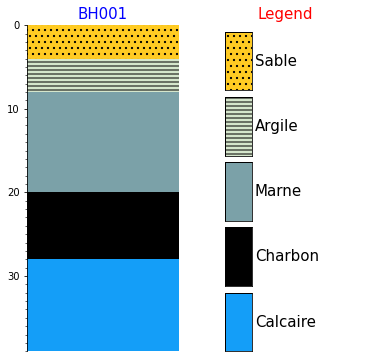

In [26]:
p.boreholes_3d[0].plot2d()

In [28]:
p.boreholes_3d[0].plot3d()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [ ]:
p.boreholes_3d[0].plot3d(x3d=True)

### Display project boreholes

### Boreholes in 3D using X3D for interaction within the notebook